# <font size="6"><b>Study Abstract</b></font> 

<font size='4'> Low-frequency blood-oxygenated-level-dependent (BOLD) signals are known to exhibit a global spatiotemporal pattern of activity at rest, labeled the quasiperiodic pattern (QPP). This spatiotemporal pattern can be described as a recurring global propagation of BOLD activity from task-positive network regions towards default mode network regions. Alongside the QPP, a wide variety of functional connectivity topographies contrasting task-positive and default mode network regions have been reported in the literature. In this study, we demonstrate that most widely-studied functional connectivity topographies arise from the same spatiotemporal dynamics - the QPP. In other words, much of the resting-state fMRI literature has been describing the same thing with different methods. Using resting-state functional magnetic resonance imaging scans from the Human Connectome Project (n=50), we examined the relationship between previously observed functional connectivity topographies and the time-lagged dynamics of the QPP. We find that the time-lagged dynamics of the QPP are distributed across multiple axes in low-dimensional functional connectivity space(s). Popular functional connectivity topographies generally correspond to one or more of these axes. Thus, functional connectivity topographies represent low-dimensional descriptions of the synchronous dynamics within the larger time-lagged QPP pattern. We further demonstrate that ‘global signal’ and ‘task-positive/task-negative’ functional connectivity topographies arise from the same dynamics of the QPP: a time-lag in BOLD signals between task-positive and task-negative network regions. Overall, we find that the QPP underlies a striking variety of previously observed phenomena in low-frequency resting-state BOLD signals.</font>

## Module Imports

In [5]:
import ipyplot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nb
import numpy as np
import pickle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import random as rand
from scipy import linalg
from scipy.signal import resample
from scipy.stats import zscore
from sklearn.decomposition import KernelPCA, PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import MDS, Isomap
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
from utils.utils import load_data_and_stack, load_gifti, pull_gifti_data, load_cifti, pull_cifti_data, \
write_to_gifti, double_gamma_hrf, convolve_hrf_events


## Helper Functions

In [6]:
# Global variables
tr = 0.72

# Helper Functions
def axis3d_scaler(x, y, z):
    # https://stackoverflow.com/questions/30223161/matplotlib-mplot3d-how-to-increase-the-size-of-an-axis-stretch-in-a-3d-plot
    scale=np.diag([x, y, z, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0
    return scale  


def create_hrf_group(n_ts, activation_indx, ts_len, tr, amplitude, phase_jitter, 
                     amplitude_jitter, ts_sampling=0.01, repeat_n=1):
    """
    n_ts: number of timeseries
    activation_indx = index of activation time point
    ts_len: length of time series
    tr: the sampling rate of the original time series
    amplitude: amplitude of double gamma function 
    phase_offset_window: allowable phase offsets between time series - 
        set as a symmetric window length - sampled from uniform distribution
    ts_sampling: resolution of original time series - default=0.01 Hz
    std_noise: amount of gaussian noise to add to time series - scaling parameter between 0 and 1
    """
    hrf=double_gamma_hrf(60, ts_sampling)
    ts_all = np.zeros((n_ts, ts_len))
    for n in range(n_ts):
        ts = ts_all[n,:]
        indx = rand.randint(activation_indx - phase_jitter, 
                          activation_indx + phase_jitter)
        amp = rand.randint(amplitude - amplitude_jitter, 
                           amplitude + amplitude_jitter)
        ts[indx] = 1
        ts_all[n,:] = (convolve_hrf_events(hrf, ts) * amplitude)
    n_resample=np.int(ts_sampling*ts_len/tr)
    hrf_ts_resample = resample(ts_all, n_resample, axis=1)
    return np.tile(hrf_ts_resample, repeat_n)


def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)


def image_3d(ax, arr, label, xy, offset_x, offset_y, label_offset_y=0, zoom=0.05, pad=0):
    """ Place an image (arr) as annotation at position xy 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    im = OffsetImage(arr, zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, xy, xybox=(offset_x, offset_y),
                        xycoords='data', boxcoords="offset points",
                        pad=pad, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    offsetbox = TextArea(label, minimumdescent=False)
    ab = AnnotationBbox(offsetbox, xy,
                    xybox=(offset_x, offset_y+label_offset_y),
                    xycoords='data',
                    boxcoords=("offset points"))
    
    ax.add_artist(ab)


def proj_3d(X, ax1, ax2):
    """ From a 3D point in axes ax1, 
        calculate position in 2D in ax2 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))


def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
        0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


def transition_matrix(transitions):
    #https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
    n = 1 + np.int(np.nanmax(transitions)) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        if ~np.isnan(i) and ~np.isnan(j):
            M[np.int(i)][np.int(j)] += 1
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)


def xcorr(x, y, maxlags=30):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    c = np.correlate(x, y, mode=2)
    c /= np.sqrt(np.dot(x, x) * np.dot(y, y))
    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)
    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    max_r = c[np.argsort(np.abs(c))[-1]]
    max_lag = lags[np.argsort(np.abs(c))[-1]]
    return max_r, max_lag


# <b>Figure 1 - Time-lag Dynamics of the QPP (Movies).</b>

### Quasiperiodic Pattern Movie

In [13]:
%%HTML
<header>
    <h4>Quasiperiodic Pattern - Top Left of Figure</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/qpp_rest_text.mp4"
        type="video/mp4">                                                       
</video>

### EEOF First and Second Principal Component Movie 

In [12]:
%%HTML

<header>
    <h4>First Principal Component - Top right of figure</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component0_text.mp4"
        type="video/mp4">                                                       
</video>
<header>
    <h4>Second Principal Component</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component1_text.mp4"
        type="video/mp4">                                                       
</video>

### Figure 1 Caption

Illustration of the time-lag dynamics of the QPP from the auto-regressive template matching algorithm, extended empirical orthogonal functions, complex hilbert empirical orthogonal functions, and cortical lag projections. The averaged spatiotemporal template from the auto-regressive template matching algorithm is displayed as a movie in the upper left corner. Time series values from each cortical vertex are z-score normalized and displayed in colors from light green (negative) to yellow (positive) BOLD values. The averaged spatiotemporal template displays the characteristic dynamics of slightly over half the overall QPP pattern: beginning positive peak BOLD amplitudes in the TP network that later propagates towards the TN/DMN network. The spatiotemporal weights from the first extended empirical orthogonal are displayed as a movie in the upper right corner with the same colormap as the averaged template. The time series represents the spatial weights of each vertex at each point in time over a fixed window (50 TRs). The first component displays the full QPP pattern: beginning positive peak BOLD amplitudes in the TP network that later propagates towards the TN/DMN networks, followed by a mirrored negative propagation event with the same pattern. The real, imaginary and phase offset maps of the first component from the complex Hilbert empirical orthogonal function analysis are displayed in the bottom of the map. The real and imaginary component weights are read similarly to principal component maps from conventional PCA, except that the imaginary component is the spatial pattern of the principal component shifted forward in time by /2. The spatial pattern of the real component precisely matches the beginning phase of the global propagation event of the QPP. The imaginary component seems to correspond to the latter end of the QPP - where the BOLD signals of the TN/DMN are decaying. The colormap of the phase delay map is read backwards: it is the phase difference between the vertex BOLD signal and the component time series - i.e. BOLD signals with maximum correlation at a later time than the component time series are at a negative phase shift, and signals with maximum correlation at an earlier time is a positive phase shift. Reading our phase delay map backwards then: the first complex component peak precisely matches the dynamics of the QPP: early peak amplitudes in the TP, followed by propagation of peak amplitudes toward the TN/DMN. The cortical lag projection map is displayed in the bottom right of the figure. The cortical lag projection map represents the average time-lag difference between each vertex of the cortex. The colormap reads forward: negative values precede positive values in time. The average time-lags of the cortical lag projection precisely match the phase delay map of the first complex hilbert component, and the time-lag dynamics of the QPP. 


# <b>Figure 2 - Survey of Zero-lag FC Topographies.</b>

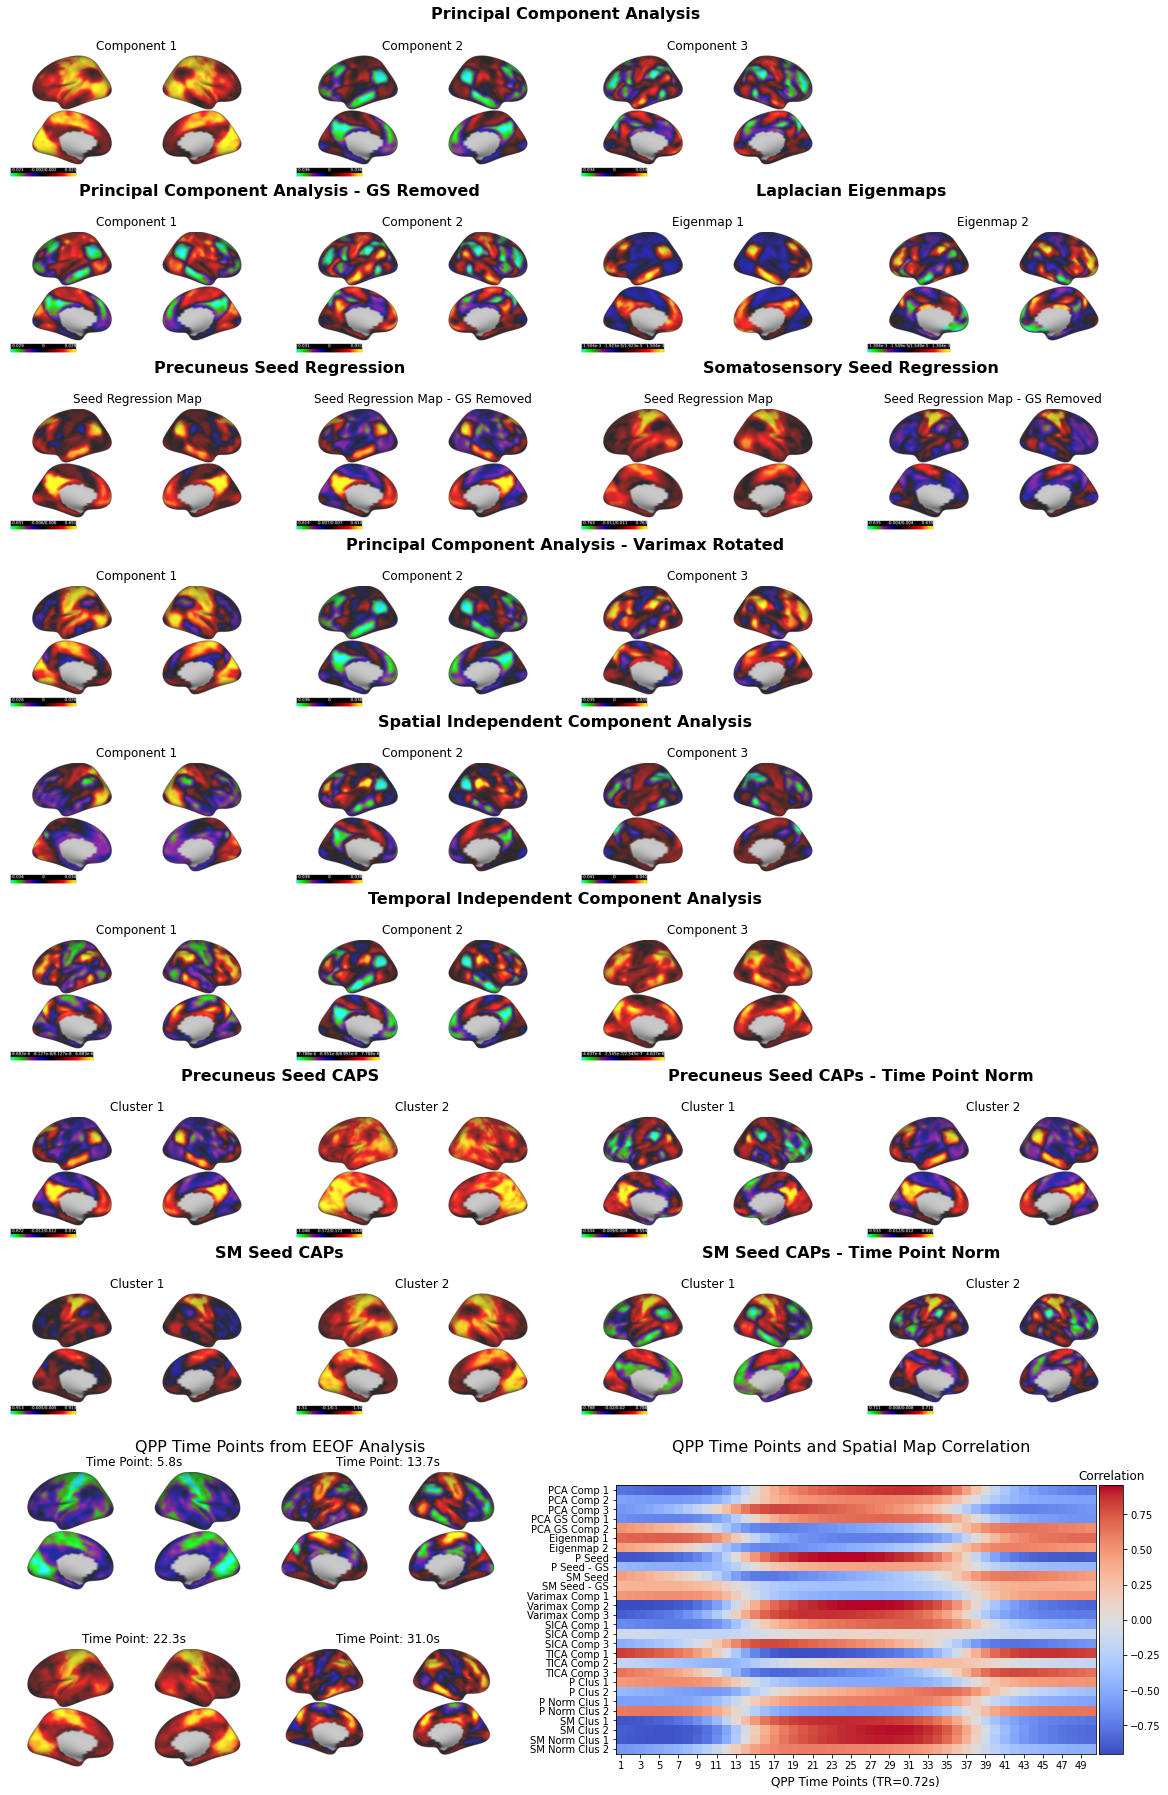

In [8]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
    'demo_files/diffusion_embedding.dtseries.nii', 'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/fc_map_precuneus.dtseries.nii', 'demo_files/fc_map_gs_precuneus.dtseries.nii',
    'demo_files/fc_map_sm.dtseries.nii', 'demo_files/fc_map_gs_sm.dtseries.nii', 
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
    'demo_files/caps_precuneus_c2.dtseries.nii', 'demo_files/caps_precuneus_norm_c2.dtseries.nii',
    'demo_files/caps_sm_c2.dtseries.nii', 'demo_files/caps_sm_norm_c2.dtseries.nii'
)
fps = (
    ['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
    [['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png'],
     ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png']], 
    [['demo_files/fc_map_precuneus.png', 'demo_files/fc_map_precuneus_gs.png'],
     ['demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png']], 
    ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 'demo_files/pca_rest_varimax_comp2.png'], 
    ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
    ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png'], 
    [['demo_files/caps_precuneus_cluster0_c2.png', 'demo_files/caps_precuneus_cluster1_c2.png'],
     ['demo_files/caps_precuneus_norm_cluster0_c2.png', 'demo_files/caps_precuneus_norm_cluster1_c2.png']],
    [['demo_files/caps_sm_cluster0_c2.png', 'demo_files/caps_sm_cluster1_c2.png'],
     ['demo_files/caps_sm_norm_cluster0_c2.png', 'demo_files/caps_sm_norm_cluster1_c2.png']]
)
labels = (
    ['Component 1', 'Component 2', 'Component 3'],
    [['Component 1', 'Component 2'], ['Eigenmap 1', 'Eigenmap 2']], 
    [['Seed Regression Map', 'Seed Regression Map - GS Removed'], ['Seed Regression Map', 'Seed Regression Map - GS Removed']],
    ['Component 1', 'Component 2', 'Component 3'], 
    ['Component 1', 'Component 2', 'Component 3'], 
    ['Component 1', 'Component 2', 'Component 3'],
    [['Cluster 1', 'Cluster 2'], ['Cluster 1', 'Cluster 2']],
    [['Cluster 1', 'Cluster 2'], ['Cluster 1', 'Cluster 2']]
)
labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA GS Comp 1', 'PCA GS Comp 2',
    'Eigenmap 1', 'Eigenmap 2', 'P Seed', 'P Seed - GS', 'SM Seed', 'SM Seed - GS',
    'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 
    'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3', 'P Clus 1', 'P Clus 2', 
    'P Norm Clus 1', 'P Norm Clus 2', 'SM Clus 1', 'SM Clus 2', 'SM Norm Clus 1', 
    'SM Norm Clus 2'
)
section_labels = (
    'Principal Component Analysis', 
    ['Principal Component Analysis - GS Removed', 'Laplacian Eigenmaps'],
    ['Precuneus Seed Regression', 'Somatosensory Seed Regression'], 
    'Principal Component Analysis - Varimax Rotated', 
    'Spatial Independent Component Analysis', 
    'Temporal Independent Component Analysis', 
    ['Precuneus Seed CAPS', 'Precuneus Seed CAPs - Time Point Norm'], 
    ['SM Seed CAPs', 'SM Seed CAPs - Time Point Norm']
)

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()


fig = plt.figure(figsize=(20,32), constrained_layout=False)
gspec = fig.add_gridspec(10, 4, wspace=0.1)


for row, sec_labels in enumerate(section_labels, start=0):
    if isinstance(sec_labels, list):
        big_ax00 = fig.add_subplot(gspec[row,:2])
        big_ax01 = fig.add_subplot(gspec[row,2:])
        big_ax00.set_title(f"{sec_labels[0]}\n", fontsize=16, fontweight='bold')
        big_ax01.set_title(f"{sec_labels[1]}\n", fontsize=16, fontweight='bold')
        # Turn off axis lines and ticks of the big subplot 
        big_ax00.axis('off'); big_ax01.axis('off')
    else:
        big_ax = fig.add_subplot(gspec[row,:])
        big_ax.set_title(f"{sec_labels}\n", fontsize=16, fontweight='bold')
        # Turn off axis lines and ticks of the big subplot 
        big_ax.axis('off')

indx = 0
for fp_sec, label_sec in zip(fps, labels):
    if all(isinstance(i, list) for i in label_sec):
        label_flat = [label for label_two in label_sec for label in label_two]
        fp_flat = [fp for fp_two in fp_sec for fp in fp_two]
        for j in range(4):
            ax00 = fig.add_subplot(gspec[indx,j])
            img = mpimg.imread(fp_flat[j])
            ax00.set_title(label_flat[j])
            ax00.imshow(img)
            ax00.axis('off')
    else:
        for j in range(3):
            ax00 = fig.add_subplot(gspec[indx,j])
            if j <= (len(fp_sec) - 1):
                img = mpimg.imread(fp_sec[j])
                ax00.set_title(label_sec[j])
                ax00.imshow(img)
            ax00.axis('off')
    indx += 1

_, mssa_weights, _ = pull_cifti_data(load_cifti('demo_files/mssa_comp0_w50.dtseries.nii'))
cifti_maps_n = cifti_maps_all.shape[0]
mssa_weights = mssa_weights[:, zero_mask]
corr_mat = np.corrcoef(cifti_maps_all, mssa_weights)


sub_gs = gridspec.GridSpecFromSubplotSpec(2,4, subplot_spec=gspec[8:, :], wspace=0.5)
sub_gs00 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=sub_gs[:, 2:])
ax02 = fig.add_subplot(sub_gs00[:,:])
img = plt.imshow(corr_mat[:cifti_maps_n, cifti_maps_n:], cmap='coolwarm')
divider = make_axes_locatable(ax02)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.set_title("Correlation", fontsize=12)
ax02.set_yticks(list(range(cifti_maps_n)))
ax02.set_yticklabels(labels_short)
ax02.set_xticks(np.arange(mssa_weights.shape[0]))
ax02.xaxis.set_major_locator(plt.MultipleLocator(2))
ax02.set_xticklabels(['0'] + [str(i+1) for i in np.arange(0, mssa_weights.shape[0],2)])
ax02.set_xlabel('QPP Time Points (TR=0.72s)', fontsize=12)


big_ax1 = fig.add_subplot(gspec[8:,:2])
big_ax1.set_title('QPP Time Points from EEOF Analysis', fontsize=16)
big_ax1.axis('off')

big_ax2 = fig.add_subplot(gspec[8:,2:])
big_ax2.set_title('QPP Time Points and Spatial Map Correlation', fontsize=16)
big_ax2.axis('off')

img_indx = [7, 18, 30, 42]
sub_gs01 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=sub_gs[:, :2], wspace=0)
indx = 0
for i in range(2):
    for j in range(2):
        ax03 = fig.add_subplot(sub_gs01[i,j])
        img = mpimg.imread(f'demo_files/mssa_comp0_w50_t{img_indx[indx]+1}.png')
        ax03.set_title(f'Time Point: {round((img_indx[indx]+1)*tr,1)}s')
        ax03.imshow(img)
        ax03.axis('off') 
        indx+=1    

plt.show()

### Figure 2 Caption

FC topographies of popular zero-lag analysis applied to the sample of resting-state data. Values for each cortical vertex are displayed in colors from light green (negative) to yellow (positive) BOLD values. Almost all topographies exhibit a contrast between the two ‘ends’ of the QPP:: the TP network and the TN/DMN. In the bottom left corner, time points of the QPP corresponding to the global phase (time points 6 and 22) and bipolar phase (time points 14 and 31) are displayed in the same colormap. In the bottom right corner, the spatial correlation matrix between each FC topography and all time points of the QPP are displayed. Correlation coefficient values are displayed from cool (negative) to warm (positive).  Excluding SICA Component 1 and the somatosensory-seeded correlation map on global signal regressed data, the FC topographies exhibit significant spatial correlations between time points of the QPP. 

# <b> Figure 3 - First Three Principal Components of Zero-lag Correlations.</b>

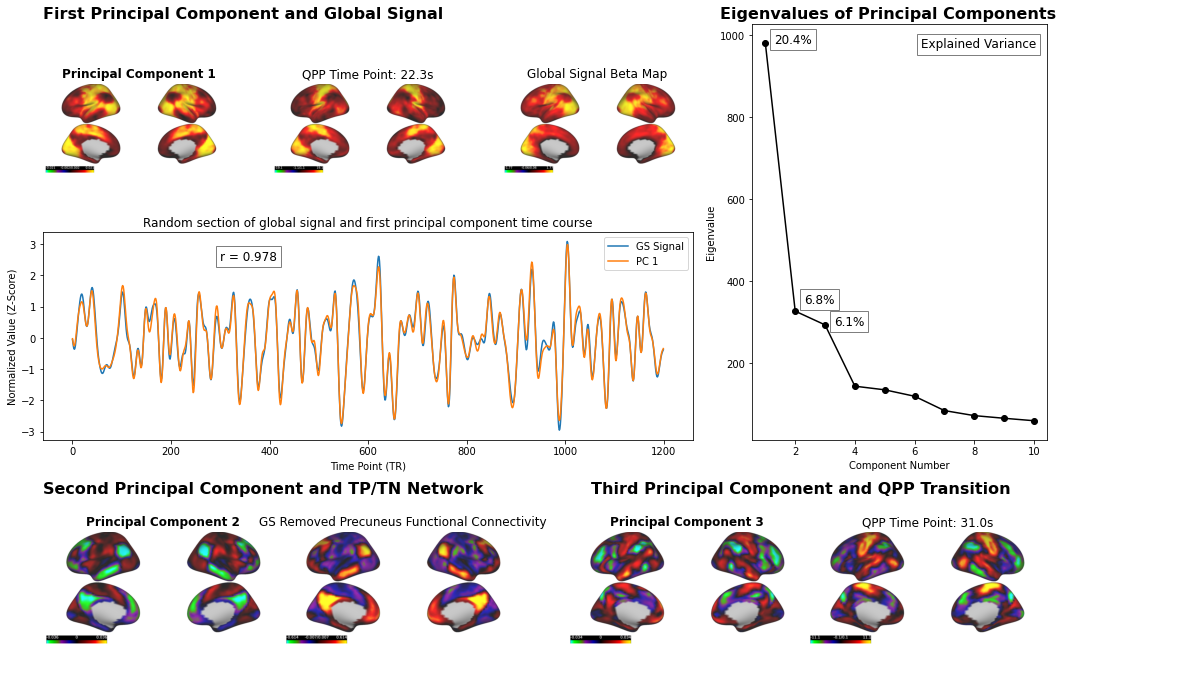

In [22]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
comp0_ts = pca_ts[:, 0]
corr_coef = np.corrcoef(comp0_ts.T, gs_signal.T)[0,1]

n_vertices = 4801
eigs = [np.var(pca_ts[:,i]) for i in range(pca_ts.shape[1])]
exp_var = [eig/n_vertices for eig in eigs]

fig = plt.figure(figsize=(18,12), constrained_layout=False)
gspec = fig.add_gridspec(2,1, wspace=0.05, height_ratios=[0.7, 0.3])

sub_big_ax = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0,:])
big_ax = fig.add_subplot(sub_big_ax[0]); big_ax.axis('off')
big_ax.set_title('First Principal Component and Global Signal', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(sub_big_ax[1]); big_ax.axis('off')
big_ax.set_title('Eigenvalues of Principal Components', fontsize=16, fontweight='bold', loc='left')
pos1 = big_ax.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0,  pos1.width, pos1.height] 
big_ax.set_position(pos2) # set a new position

sub_big_ax = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1,:])
big_ax = fig.add_subplot(sub_big_ax[0]); big_ax.axis('off')
big_ax.set_title('Second Principal Component and TP/TN Network', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(sub_big_ax[1]); big_ax.axis('off')
big_ax.set_title('Third Principal Component and QPP Transition', fontsize=16, fontweight='bold', loc='left')

   
sub_gs0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gspec[0], wspace=0.2)
sub_gs0_0 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=sub_gs0[:2], hspace=0)
sub_gs0_1 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=sub_gs0[2])
ax = fig.add_subplot(sub_gs0_0[0,0])
img = mpimg.imread('demo_files/pca_rest_comp0.png')
ax.set_title('Principal Component 1', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[0,1])
img = mpimg.imread('demo_files/mssa_comp0_w50_t31_cmap.png')
ax.set_title(f'QPP Time Point: {round(31*tr, 1)}s')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[0,2])
img = mpimg.imread('demo_files/gs_map.png')
ax.set_title('Global Signal Beta Map')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[1,:])
ax.plot(zscore(gs_signal[1200:2400]), label='GS Signal')
ax.plot(zscore(comp0_ts[1200:2400]), label='PC 1')
ax.set_title('Random section of global signal and first principal component time course', fontsize=12)
ax.set_xlabel('Time Point (TR)')
ax.set_ylabel('Normalized Value (Z-Score)')
ax.text(300,2.5, r'r = {}'.format(np.round(corr_coef,3)), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

ax = fig.add_subplot(sub_gs0_1[0])
ax.plot(list(range(1,11)), eigs, '-o', color='black')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')
x_adj = 0.3
for i in range(3):
    if i == 1:
        y_adj=20
    else:
        y_adj=0
    ax.text((i+1)+x_adj,eigs[i]+y_adj, 
            r'{}%'.format(np.round(exp_var[i]*100,1)), 
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.text(6.2, 970, 'Explained Variance', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

sub_gs1 = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gspec[1], wspace=0.2)
sub_gs1_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=sub_gs1[:2], wspace=0)
ax = fig.add_subplot(sub_gs1_0[0,0])
img = mpimg.imread('demo_files/pca_rest_comp1.png')
ax.set_title('Principal Component 2', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs1_0[0,1])
img = mpimg.imread('demo_files/fc_map_precuneus_gs.png')
ax.set_title('GS Removed Precuneus Functional Connectivity')
ax.imshow(img)
ax.axis('off')

sub_gs1_1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=sub_gs1[2:], wspace=0)
ax = fig.add_subplot(sub_gs1_1[0,0])
img = mpimg.imread('demo_files/pca_rest_comp2.png')
ax.set_title('Principal Component 3', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs1_1[0,1])
img = mpimg.imread('demo_files/mssa_comp0_w50_t19_cmap.png')
ax.set_title(f'QPP Time Point: {round(43*tr,1)}s')
ax.imshow(img)
ax.axis('off')

plt.show()

### Figure 3 Caption

FC topographies of the first three principal components. The explained variance (eigenvalue) of each principal component is displayed in decreasing order in the top right. Note, the first principal component explains more than three times the variance in cortex-wide BOLD signals than the subsequent (second) principal component. The first principal component spatial weights and time series are displayed in the upper left. The time series of the first principal component is statistically indistinguishable from the global mean time series (r=0.98), i.e. often labeled the ‘global signal.’ Further, the FC topography of the first principal component spatial weights resembles the topography of regression coefficients between each cortical vertex time series regressed on the global signal. Both the first principal component and global signal topographies resemble the global phase time points of the QPP. The FC topography of the second principal component spatial weights (bottom left) corresponds to the ‘primary functional connectivity gradient’, and precisely matches the FC topography derived from seed-based regression analysis, with seed region in the precuneus region of the DMN. The FC topography of the third principal component weights exhibits a unique spatial contrast of the TP and TN/DMN regions compared to the first two principal components. The topography precisely matches the bipolar phase time points of the QPP.


# <b> Figure 4 - QPP Dynamics in Principal Component Space.</b>

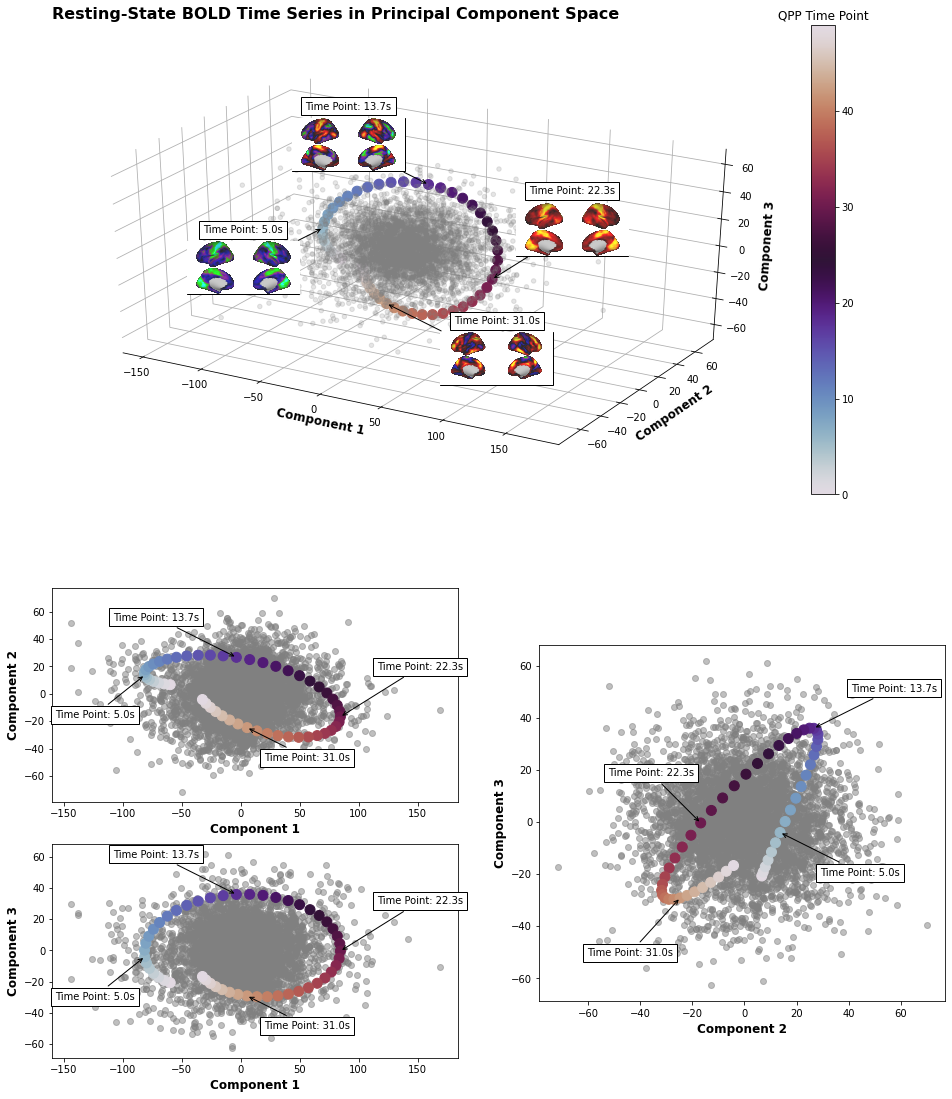

In [9]:
def short_proj():
    return np.dot(Axes3D.get_proj(ax00), scale)

pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
V = pickle.load(open('demo_files/pca_eigen.pkl', 'rb')) # X = USV
rand_indx = rand.permutation(pca_ts.shape[0])[:5000]
comp_scores = pca_ts[rand_indx, :]

fig = plt.figure(figsize=(16,19), constrained_layout=False)
gspec = fig.add_gridspec(1,1, hspace=0)

g_sub0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gspec[0])

big_ax = fig.add_subplot(g_sub0[0]); big_ax.axis('off')
big_ax.set_title('Resting-State BOLD Time Series in Principal Component Space', fontsize=16, fontweight='bold', loc='left')

x_scale=1.5
y_scale=1
z_scale=1
g_sub0_0 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=g_sub0[0])
ax00 = fig.add_subplot(g_sub0_0[0], projection='3d')
scale = axis3d_scaler(x_scale,y_scale,z_scale)
ax00.get_proj=short_proj
ax00.scatter(comp_scores[:,0], comp_scores[:,1], comp_scores[:,2], c='gray', alpha=0.2)
mssa_weights_proj = zscore(mssa_weights) @ V.T
time_indx = np.arange(50)
sp = ax00.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,1], mssa_weights_proj[:,2], 
                  c=time_indx, cmap=plt.cm.twilight, s=100, alpha=1)
cbar = plt.colorbar(sp, ax=ax00)
cbar.ax.set_title('QPP Time Point')
ax00.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax00.set_ylabel('Component 2', fontsize=12, fontweight='bold')
ax00.set_zlabel('Component 3', fontsize=12, fontweight='bold')
ax00.dist = 8

ax01 = fig.add_subplot(g_sub0_0[0], frameon=False)
ax01.axis("off")
ax01.axis([0,1,0,1])
img_indx = [6, 18, 30, 42] 
x_shift = [-80, -80, 80, 110]
y_shift = [-40, 40, 50, -55]
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    img = mpimg.imread(f'demo_files/mssa_comp0_w50_t{indx+1}.png')
    label = f'Time Point: {round((indx+1)*tr,1)}s'
    coords = (mssa_weights_proj[indx, 0], mssa_weights_proj[indx, 1], mssa_weights_proj[indx, 2])
    x,y = proj_3d(coords, ax00, ax01)
    image_3d(ax01,img,label, [x,y],offset_x,offset_y,38, 0.05)
    text_offset_x = x - 0.01/x
    text_offset_y = y + 0.01/y
    

x_shift = [-50, -80, 80, 60]
y_shift = [-40, 40, 50, -30]
g_sub0_1 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=g_sub0[1])
ax1 = fig.add_subplot(g_sub0_1[0,0])
ax1.scatter(comp_scores[:,0], comp_scores[:,1], c='gray', alpha=0.5)
ax1.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax1.set_ylabel('Component 2', fontsize=12, fontweight='bold')
im = ax1.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,1], c=time_indx, cmap=plt.cm.twilight, s=100)
# ax1.set_aspect(0.8)
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,0], mssa_weights_proj[indx,1])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax1.add_artist(ab)

ax2 = fig.add_subplot(g_sub0_1[1,0])
ax2.scatter(comp_scores[:,0], comp_scores[:,2], c='gray', alpha=0.5)
ax2.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('Component 3', fontsize=12, fontweight='bold')
im = ax2.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,2], c=time_indx, cmap=plt.cm.twilight, s=100)
# ax2.set_aspect(0.8)
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,0], mssa_weights_proj[indx,2])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax2.add_artist(ab)

ax3 = fig.add_subplot(g_sub0_1[:,1])
ax3.scatter(comp_scores[:,1], comp_scores[:,2], c='gray', alpha=0.5)
ax3.set_xlabel('Component 2', fontsize=12, fontweight='bold')
ax3.set_ylabel('Component 3', fontsize=12, fontweight='bold')
im = ax3.scatter(mssa_weights_proj[:,1], mssa_weights_proj[:,2], c=time_indx, cmap=plt.cm.twilight, s=100)
ax3.set_aspect(1)

x_shift = [80, 80, -50, -50]
y_shift = [-40, 40, 50, -55]
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,1], mssa_weights_proj[indx,2])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax3.add_artist(ab)

plt.show()

### Figure 4 Caption

Scatterplots of a random selection of principal component time series and QPP time points in principal component space. The top plot displays the 3-dimensional space formed by the first three principal components. A random selection of resting-state time points projected into principal component space (N=5000) are displayed in gray. QPP time points (N=50; from first principal component of EEOF analysis) projected into principal component space are displayed in a cyclical color map. Note, by definition, the projected resting-state time points vary greatest along the first principal component axis (three times greater than the second principal component axis). The time points of the QPP form a stretched oval appearance, enclosing the projected resting-state time points. To isolate the variance of QPP time points along each principal component axis, 2-dimensional principal component spaces formed by each pair of the first three principal components are displayed below the three-dimensional plot. The QPP time points vary most prominently along the first principal component axis. This axis differentiates the positive (e.g. ~5sec from beginning) and negative global phase (~22sec) of the QPP. Though less prominent, the positive and negative global phases of the QPP also vary along the second principal component. The bipolar phase (~14sec and ~31sec) of the QPP varies most clearly along the third principal component axis, but also slightly along the second principal component axis as well.


# <b>Figure 5. The Relationship Between the ‘Global Signal’ and ‘TP/TN’ FC Topographies.</b>

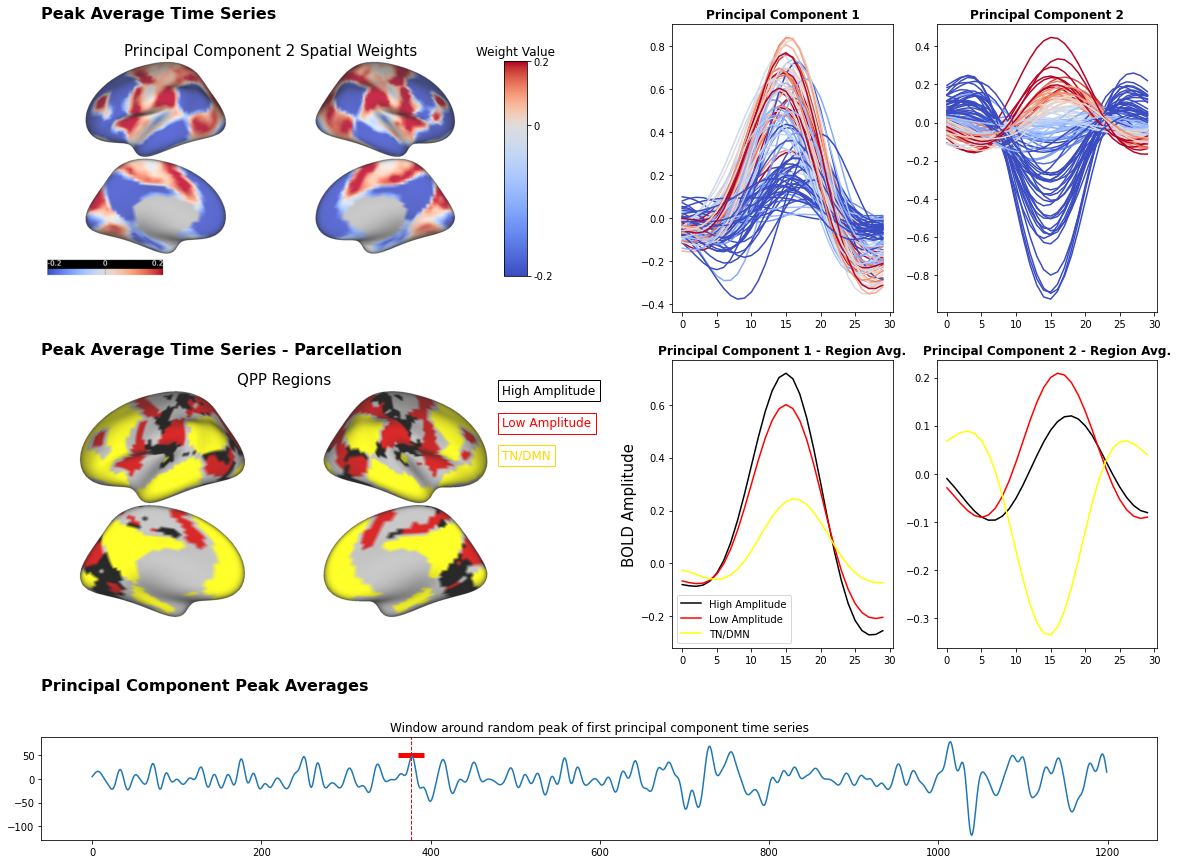

In [361]:
np.random.seed(999)
_, peak_avg_comp1, _ = pull_cifti_data(load_cifti('demo_files/peak_average_rest_comp0.dtseries.nii'))
_, peak_avg_comp2, _ = pull_cifti_data(load_cifti('demo_files/peak_average_rest_comp1.dtseries.nii'))
_, pca_comps, _ = pull_cifti_data(load_cifti('results/pca_rest.dtseries.nii'))
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
comp0_ts = pca_ts[:,0]

peak_avg_comp1 = peak_avg_comp1[:, zero_mask]
peak_avg_comp2 = peak_avg_comp2[:, zero_mask]

pr_comp1 = pca_comps[0, zero_mask]
pr_comp2 = pca_comps[1, zero_mask]

first_to_peak_mask = pr_comp1 > 0.6
later_to_peak_mask = pr_comp2 > 0.15
last_to_peak_mask = pr_comp2 < -0.1

first_ts1 = peak_avg_comp1[:, first_to_peak_mask].mean(axis=1)
later_ts1 = peak_avg_comp1[:, later_to_peak_mask].mean(axis=1)
last_ts1 = peak_avg_comp1[:, last_to_peak_mask].mean(axis=1)

first_ts2 = peak_avg_comp2[:, first_to_peak_mask].mean(axis=1)
later_ts2 = peak_avg_comp2[:, later_to_peak_mask].mean(axis=1)
last_ts2 = peak_avg_comp2[:, last_to_peak_mask].mean(axis=1)

fig = plt.figure(figsize=(20,15), constrained_layout=False)
gspec = fig.add_gridspec(3,2, wspace=0.3, width_ratios=[0.5, 0.5], height_ratios=[0.5,0.5,0.25])

big_ax = fig.add_subplot(gspec[0,:]); big_ax.axis('off')
big_ax.set_title('Peak Average Time Series', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(gspec[1,:]); big_ax.axis('off')
big_ax.set_title('Peak Average Time Series - Parcellation', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(gspec[2,0]); big_ax.axis('off')
big_ax.set_title('Principal Component Peak Averages', fontsize=16, fontweight='bold', loc='left')


sub_gs = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0,1], wspace = 0.2)
random_indx = np.random.permutation(peak_avg_comp1.shape[1], )[:100]
pr_comp2_norm = minmax_scale(pr_comp2)
# Recenter cool-warm color map to match cool-warm brain color map from HCP Workbench - this was estimated visually
cmap = cm.get_cmap('coolwarm')
new_cmap = shiftedColorMap(cmap, midpoint=0.7)
sm = ScalarMappable(cmap=new_cmap)
sm.set_clim(0.5, 0.85)
color_array = np.array([[0,1]])

ax = fig.add_subplot(gspec[0,0])
img = ax.imshow(color_array, cmap=new_cmap)
img.set_visible(False)
img2 = mpimg.imread(f'demo_files/pca_rest_comp1_coolwarm.png')
ax.set_title(f'Principal Component 2 Spatial Weights', fontsize=15)
ax.imshow(img2)
ax.axis('off') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cmap=sm, cax=cax, ticks=[0, 0.7, 1])
cbar.ax.set_yticklabels([-0.2, 0, 0.2]) 
cax.set_title('Weight Value')

ax = fig.add_subplot(sub_gs[0,0])
for i in random_indx:
    color = sm.to_rgba(pr_comp2_norm[i])
    ax.plot(peak_avg_comp1[:, i], color=color)
    ax.set_title('Principal Component 1', fontweight='bold')

ax = fig.add_subplot(sub_gs[0,1])
for i in random_indx:
    color = sm.to_rgba(pr_comp2_norm[i])
    ax.plot(peak_avg_comp2[:, i], color=color)
    ax.set_title('Principal Component 2', fontweight='bold')


ax = fig.add_subplot(gspec[1,0])
img = mpimg.imread(f'demo_files/qpp_parcellation.png')
ax.set_title(f'QPP Regions', fontsize=15)
ax.imshow(img)
ax.axis('off') 
offsetbox = TextArea(f'High Amplitude', minimumdescent=False, textprops=dict(size=12, color='black'))
ab = AnnotationBbox(offsetbox, (0.5,0.55),
                    xybox=(0.95, 0.1),
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(0., 0.5),
                    bboxprops=dict(facecolor='none', edgecolor='black')
                   )
ax.add_artist(ab)
offsetbox = TextArea(f'Low Amplitude', minimumdescent=False, textprops=dict(size=12, color='red'))
ab = AnnotationBbox(offsetbox, (0.5,0.55),
                    xybox=(0.95, 0.1),
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(0., 3),
                    bboxprops=dict(facecolor='none', edgecolor='red')
                   )
ax.add_artist(ab)
offsetbox = TextArea(f'TN/DMN', minimumdescent=False, textprops=dict(size=12, color='gold'))
ab = AnnotationBbox(offsetbox, (0.5,0.55),
                    xybox=(0.95, 0.1),
                    boxcoords=("axes fraction", "data"),
                    box_alignment=(0., 5.5),
                    bboxprops=dict(facecolor='none', edgecolor='gold')
                   )
ax.add_artist(ab)

sub_gs = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1,1], wspace = 0.2)
ax = fig.add_subplot(sub_gs[0,0])
ax.plot(first_ts1, label='High Amplitude', c='black')
ax.plot(later_ts1, label='Low Amplitude', c='red')
ax.plot(last_ts1, label='TN/DMN', c='yellow')
ax.set_ylabel('BOLD Amplitude', fontsize=15)
ax.set_title('Principal Component 1 - Region Avg.', fontweight='bold')
ax.legend()

ax = fig.add_subplot(sub_gs[0,1])
ax.plot(first_ts2, label='first-to-peak', c='black')
ax.plot(later_ts2, label='later-to-peak', c='red')
ax.plot(last_ts2, label='last-to-peak', c='yellow')
ax.set_title('Principal Component 2 - Region Avg.', fontweight='bold')


ax = fig.add_subplot(gspec[2,:])
ax.axis('off')
divider = make_axes_locatable(ax)
sub_ax = divider.append_axes("bottom", size="250%", pad=0)
sub_ax.plot(comp0_ts[:1200])
sub_ax.set_title('Window around random peak of first principal component time series')
sub_ax.axvline(377, linestyle='--', c='r', linewidth=1)
sub_ax.hlines(50, xmin=362, xmax=392, linewidth=5, color='r')

plt.show()

In [14]:
%%HTML
<table>
    <tr>
        <td>
            <header>
                <h4 style='text-align:center'>Principal Component 1 - Peak Average</h4>
            </header>
            <video controls autoplay loop width="450" height="400">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component0_text.mp4"
                    type="video/mp4"
            </video>
        </td>
        <td>
            <header>
                <h4 style='text-align:center'>Principal Component 2 - Peak Average</h4>
            </header>
            <video controls autoplay loop width="450" height="400">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component1_text.mp4"
                    type="video/mp4">                                                       
            </video>
        
        </td>
        <td>
            <header>
                <h4 style='text-align:center'>Principal Component 1 - Peak Average - GS Removed</h4>
            </header>
            <video controls autoplay loop width="450" height="400">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component0_gs_text.mp4"
                    type="video/mp4">                                                       
            </video>
        
        </td>
    </tr>
</table>

#### Figure 5 Caption

BOLD dynamics associated with the first (‘global signal’) and second (‘TP/TN’) principal components are illustrated with averaging around a fixed window (15TRs each side) of randomly sampled peaks in each principal component time series. The top plot illustrates the dynamics of peak-averaged time series for each component from 100 randomly sampled cortical vertices. The peak-averaged time series from each vertex is colored according to their spatial weight value on the second principal component (shown in the top left). Peak-averaged time series are colored from cool to warm, reflecting negative (DMN/TN) versus positive (TP) spatial weight values on the second principal component, respectively. Warm colored peak-average time series belong to TP network regions that exhibit early and strong peak BOLD amplitudes in the first principal component time series. Cool colored peak-average time series belong to DMN/TN network regions that exhibit later and weak peak BOLD amplitudes in the first principal component time series. Due to global signal regression, or orthogonalization with respect to the first principal component, the same cortical vertices now exhibit an anti-phase relationship between TP (warm) network vertices and TN/DMN (cool) vertices. To make this relationship more clear, we parcellated the cortex into high-amplitude TP regions in black (vertices exhibiting spatial weight values exceeding r > 0.6 on the first principal component), low-amplitude TP regions in red (r > 0.15 on the second principal component), and TN/DMN regions in yellow (r <  -0.1 on the second principal component). This is displayed in the middle plot. We averaged peak-averaged time series from each vertex within these three regions for both first and second principal component time series. As observed in the individual cortical time series (top plot), TP regions exhibit early and strong peak BOLD amplitudes in the region-averaged time series of the first principal component; TN/DMN regions exhibit late and weak BOLD amplitudes. Due to global signal regression, the anti-phase relationships between the TP and TN/DMN is observed in the second principal component time series. In the bottom plot, we display the peak-averaged time series from each vertex for the first and second principal component as movies. To more directly demonstrate the effects of global signal regression on the first principal component time series, we conducted the same peak-averaging procedure with global signal regression conducted beforehand, and displayed the time series as a movie. Note, the first principal component time series were derived from the original data, not the global-signal regressed data. When we average global-signal regressed time series around the peaks of the original first principal component, we observe the same anti-phased relationship between TP network and TN/DMN regions observed in the second principal component. 

# <b>Figure 6.  Co-activation Patterns in Principal Component Space.</b>

CAP cluster centroids were previously projected into principal component space before the code below (see <b>Appendix H</b>)

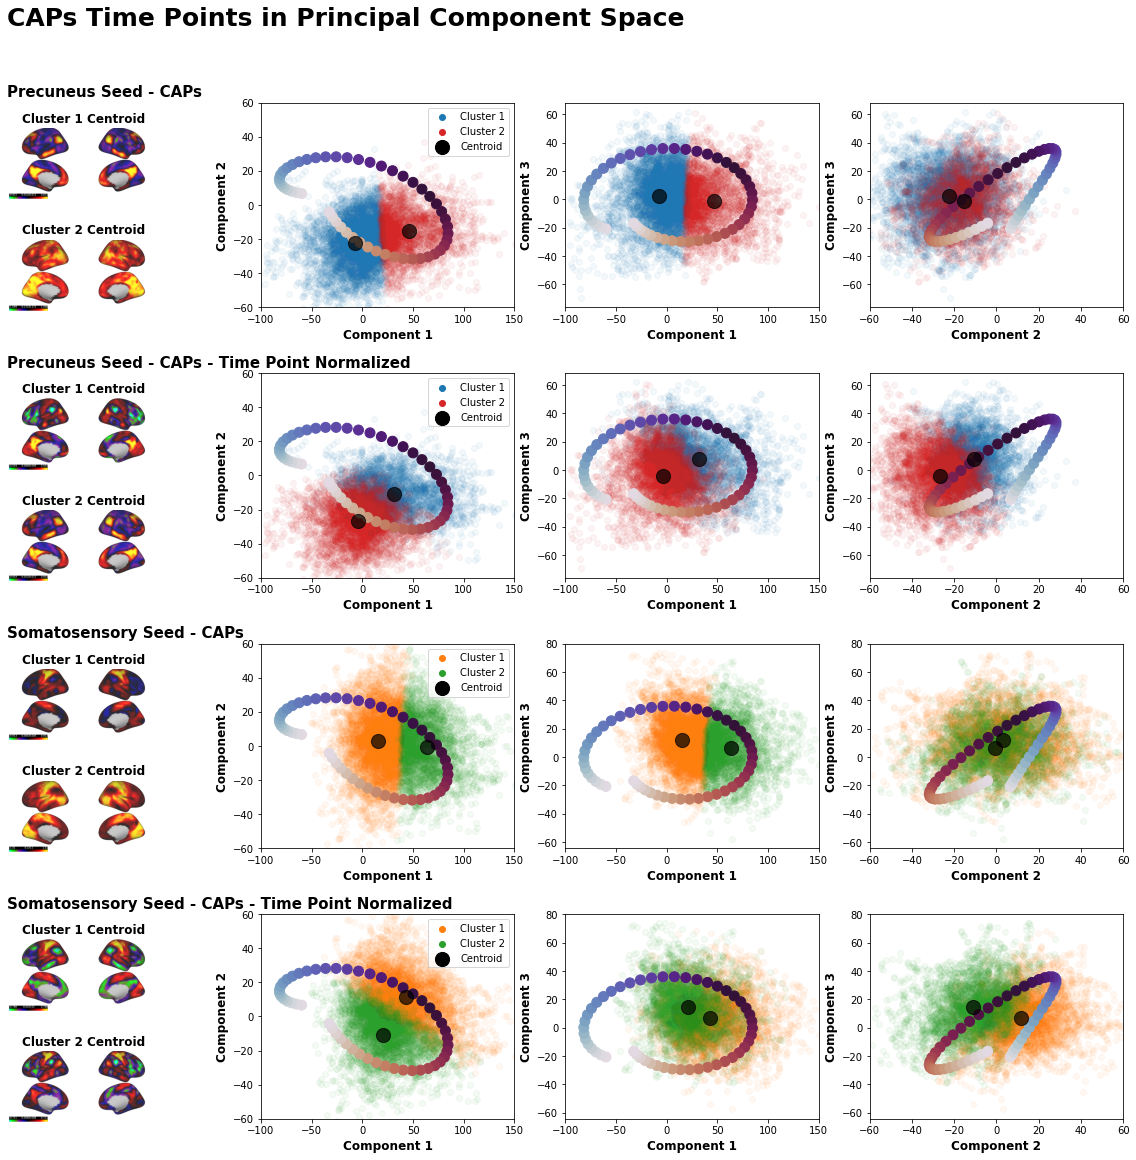

In [366]:
fps = [['demo_files/caps_precuneus_cluster0_c2.png', 'demo_files/caps_precuneus_cluster1_c2.png'],
       ['demo_files/caps_precuneus_norm_cluster0_c2.png', 'demo_files/caps_precuneus_norm_cluster1_c2.png'],
       ['demo_files/caps_sm_cluster0_c2.png', 'demo_files/caps_sm_cluster1_c2.png',], 
       ['demo_files/caps_sm_norm_cluster0_c2.png', 'demo_files/caps_sm_norm_cluster1_c2.png']]
section_labels = ['Precuneus Seed - CAPs', 'Precuneus Seed - CAPs - Time Point Normalized', 
                  'Somatosensory Seed - CAPs', 'Somatosensory Seed - CAPs - Time Point Normalized']
supra_thres_ts = pickle.load(open('demo_files/caps_suprathres_points.pkl', 'rb')) # X = USV
caps_p_res = pickle.load(open('results/caps_precuneus_results_c2.pkl', 'rb'))
caps_p_res_norm = pickle.load(open('results/caps_precuneus_norm_results_c2.pkl', 'rb'))
caps_sm_res = pickle.load(open('results/caps_sm_results_c2.pkl', 'rb'))
caps_sm_res_norm = pickle.load(open('results/caps_sm_norm_results_c2.pkl', 'rb'))

clus_labels_all = [caps_p_res[1], caps_p_res_norm[1], caps_sm_res[1], caps_sm_res_norm[1]]

fig = plt.figure(figsize=(20,20))
gspec = fig.add_gridspec(5,1, hspace=0.4, height_ratios=[0.005,0.2,0.2,0.2,0.2])

ax = fig.add_subplot(gspec[0:]); ax.axis('off')
ax.set_title('CAPs Time Points in Principal Component Space', fontsize=25, fontweight='bold', loc='left')

for indx in range(4):
    big_ax = fig.add_subplot(gspec[(indx+1):]); big_ax.axis('off')
    big_ax.set_title(section_labels[indx], fontsize=15, fontweight='bold', loc='left')

cm = plt.cm.get_cmap('tab20')
xy_ax_ord = [[0,1], [0,2], [1,2]]
color_list = [[cm(0), cm(6)], [cm(0), cm(6)], [cm(2), cm(4)], [cm(2), cm(4)]]
for i in range(4):
    if i < 2:
        time_points = supra_thres_ts[0]
    else:
        time_points = supra_thres_ts[1]
    colors = color_list[i]
    g_sub = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[i+1], width_ratios=[0.15, 0.85])
    g_sub0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=g_sub[0])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[1])
    clus_labels = clus_labels_all[i]
    clus_1_indx = np.where(clus_labels == 0)[0]
    clus_2_indx = np.where(clus_labels == 1)[0]
    clus_1_centroid = np.mean(time_points[clus_1_indx, :],axis=0)
    clus_2_centroid = np.mean(time_points[clus_2_indx, :],axis=0)
    for indx, fp in enumerate(fps[i]):
        ax = fig.add_subplot(g_sub0[indx])
        img = mpimg.imread(fp)
        ax.set_title(f'Cluster {indx+1} Centroid', fontweight='bold')
        ax.imshow(img)
        ax.axis('off')
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 - 0.01,  pos1.width, pos1.height] 
        ax.set_position(pos2) # set a new position
    for j in range(3):
        ax = fig.add_subplot(g_sub1[j])
        x, y = xy_ax_ord[j]
        ax.scatter(time_points[clus_1_indx,x], time_points[clus_1_indx,y], 
                   color=colors[0], alpha=0.05, label='Cluster 1')
        ax.scatter(time_points[clus_2_indx,x], time_points[clus_2_indx,y], 
                   color=colors[1], alpha=0.05, label='Cluster 2')
        im = ax.scatter(mssa_weights_proj[:,x], mssa_weights_proj[:,y], c=time_indx, cmap=plt.cm.twilight, s=100)
        ax.scatter(clus_1_centroid[x], clus_1_centroid[y], 
                    c='black', alpha=0.7, s=200, label='Centroid')
        ax.scatter(clus_2_centroid[x], clus_2_centroid[y], 
                    c='black', alpha=0.7, s=200)
        ax.set_xlabel(f'Component {x+1}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Component {y+1}', fontsize=12, fontweight='bold')
        if x == 0:
            ax.set_xlim([-100, 150])
        elif x == 1:
            ax.set_xlim([-60, 60])
        if y == 1:
            ax.set_ylim([-60, 60])
        if j == 0:
            leg = ax.legend()
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
plt.savefig('results/figures/CAP_analysis.png')
# plt.show()

### Figure 6 Caption

To examine the relationship between CAP clusters, the first three principal components, and the QPP, we projected the suprathreshold time points and cluster centroids for both the precuneus and somatosensory seeds, and the QPP time points, onto the first three principal component space (in a manner similar to that illustrated in Figure 4). Specifically, we first projected the suprathreshold time points (top 15% threshold) from the precuneus and somatosensory seeds onto the first three principal component axes, colored by each time points cluster assignment. Note, the suprathreshold time points are identical between the non-normalized and normalized data, the difference is purely whether each time point was normalized before application of the K-Means clustering algorithm. Additionally, we plotted the precuneus and somatosensory seed cluster centroids (black) for both the original and time-point normalized suprathreshold time points in the same space. Note, the cluster number for each CAPs analysis is arbitrary and there is no relationship between the cluster assignments of the two seeds. For non-normalized time points, cluster centroids for both precuneus and somatosensory seeds vary most strongly along the first principal component axis. For normalized time points, cluster centroids vary most strongly along the second principal component axis.


# <b>Supplementary Figures</b>

# <b>Supplementary Figure A - Functional Connectivity Topographies in Similarity Space</b>

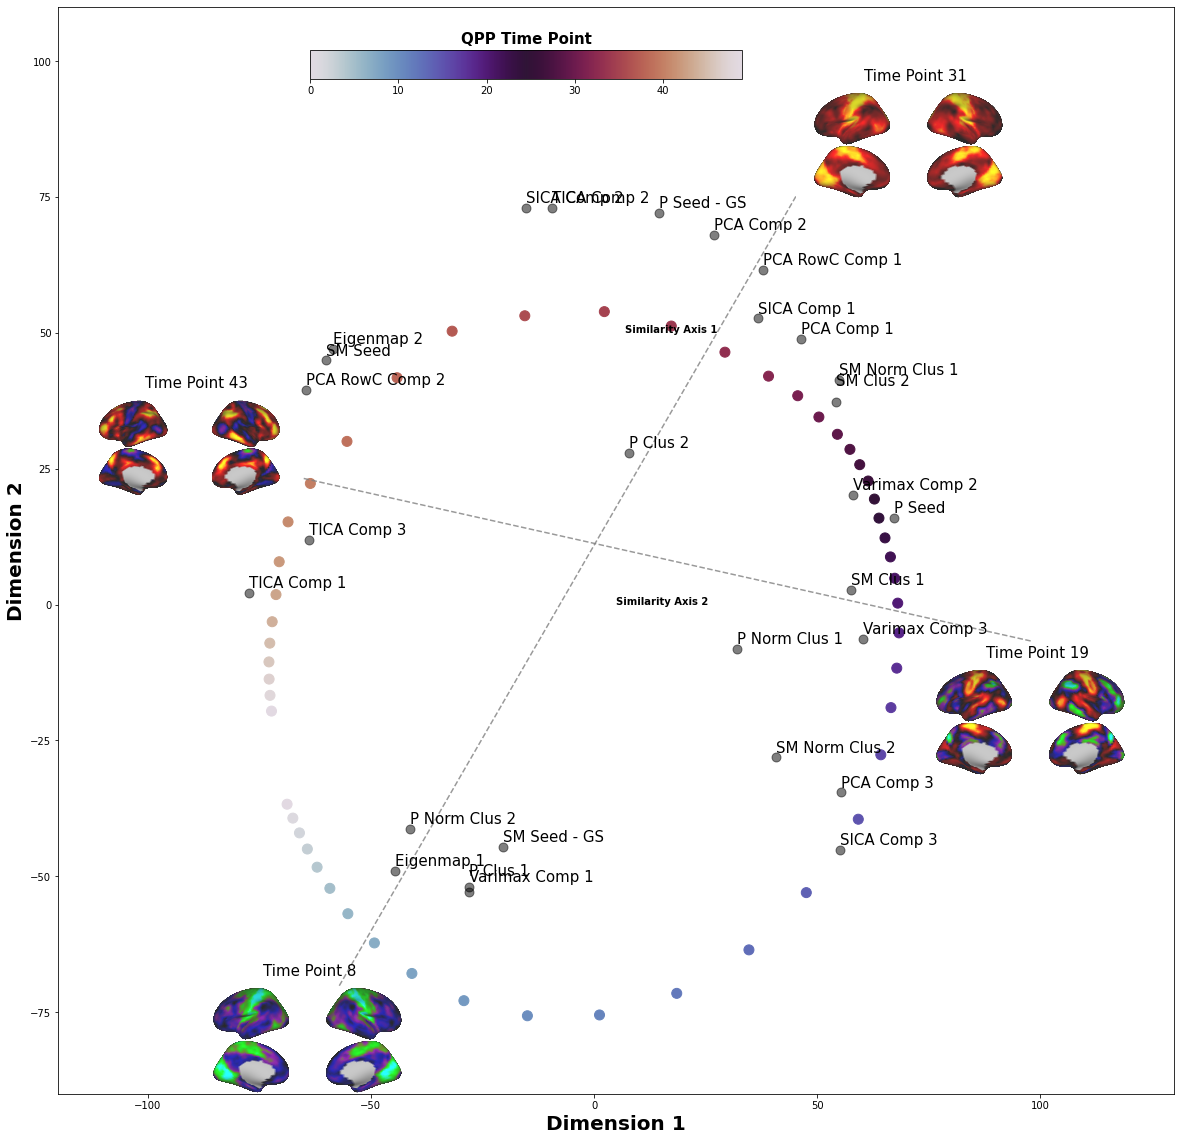

In [53]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
    'demo_files/diffusion_embedding.dtseries.nii', 'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/fc_map_precuneus.dtseries.nii', 'demo_files/fc_map_gs_precuneus.dtseries.nii',
    'demo_files/fc_map_sm.dtseries.nii', 'demo_files/fc_map_gs_sm.dtseries.nii', 
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
    'demo_files/caps_precuneus_c2.dtseries.nii', 'demo_files/caps_precuneus_norm_c2.dtseries.nii',
    'demo_files/caps_sm_c2.dtseries.nii', 'demo_files/caps_sm_norm_c2.dtseries.nii'
)
labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA RowC Comp 1', 'PCA RowC Comp 2',
    'Eigenmap 1', 'Eigenmap 2', 'P Seed', 'P Seed - GS', 'SM Seed', 'SM Seed - GS',
    'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 
    'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3', 'P Clus 1', 'P Clus 2', 
    'P Norm Clus 1', 'P Norm Clus 2', 'SM Clus 1', 'SM Clus 2', 'SM Norm Clus 1', 
    'SM Norm Clus 2'
)

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()

_, mssa_weights, _ = pull_cifti_data(load_cifti('demo_files/mssa_comp0_w50.dtseries.nii'))
mssa_weights = mssa_weights[:, zero_mask]

all_maps = np.vstack([mssa_weights, cifti_maps_all])
comp_scores = PCA(n_components=50).fit_transform(zscore(all_maps.T).T)
mds = MDS(random_state=1)
mds.fit(comp_scores)
embeddings = mds.embedding_
time_indx = np.arange(50)


fig, ax = plt.subplots(figsize=(20,20))

img_indx = [7, 18, 30, 42]
shift_x = [-15, 30, 20, -20]
shift_y = [-18, -10, 50, 20]
for indx, x_s, y_s in zip(img_indx, shift_x, shift_y):
    x, y = embeddings[indx,0], embeddings[indx, 1]
    ab = AnnotationBbox(getImage(f'demo_files/mssa_comp0_w50_t{indx+1}.png'), 
                        (x+x_s, y+y_s), frameon=False)
    ax.add_artist(ab)
    ax.text(x+x_s-10, y+y_s+12, f'Time Point {indx+1}', fontsize=15)

ax1_coord = [(embeddings[img_indx[0],0]+shift_x[0], embeddings[img_indx[2],0] + shift_x[2]-15), 
             (embeddings[img_indx[0],1]+shift_y[0], embeddings[img_indx[2],1] + shift_y[2]+5)]
ax2_coord = [(embeddings[img_indx[1],0]+shift_x[1], embeddings[img_indx[3],0] + shift_x[3]), 
             (embeddings[img_indx[1],1]+shift_y[1]+15, embeddings[img_indx[3],1] + shift_y[3])]
ax.plot(ax1_coord[0], ax1_coord[1], '--', c='grey', alpha=0.8)
ax.plot(ax2_coord[0], ax2_coord[1], '--', c='grey', alpha=0.8)

s = ax.scatter(embeddings[:50,0], embeddings[:50,1], s=100, c=time_indx, cmap=plt.cm.twilight)
cbar = plt.colorbar(s, ax=ax, orientation='horizontal', cax = fig.add_axes([0.3, 0.83, 0.3, 0.02]))
cbar.ax.set_title('QPP Time Point', fontsize=15, fontweight='bold')

ax.scatter(embeddings[50:,0], embeddings[50:, 1], s=80, c='black', alpha=0.5) 
for i, label in enumerate(labels_short):
    if label in ['SM Clus 2', 'P Clus 1']:
        y_shift=3
    else:
        y_shift=1
    ax.annotate(label, (embeddings[50+i,0], embeddings[50+i,1]+y_shift), fontsize=15)
ax.text(5,0, 'Similarity Axis 2', fontweight='bold')
ax.text(7,50, 'Similarity Axis 1', fontweight='bold')

ax.set_ylim(-90, 110)
ax.set_xlim(-120, 130)
ax.set_xlabel('Dimension 1', fontsize=20, fontweight='bold')
ax.set_ylabel('Dimension 2', fontsize=20, fontweight='bold')
# plt.show()
plt.savefig('results/figures/supplementary_A_topography_comparison.png')

### Figure A Caption

(P=Precuneus, SM=somatosensory, GS=global signal, seed=seed-based correlation analysis, clus=centroids from CAP analysis). To further understand the similarities among zero-lag FC topographies, and how they related to time points of the QPP, we projected all FC topographies and QPP time points into a 2-dimensional similarity space using multidimensional scaling. The spatial similarity between FC topographies is expressed by the distance between them in this 2-dimensional space. For reference, the spatial maps at each time point of the QPP are colored using a cyclical color map, from time point 0 to time point 50. In addition, spatial maps of chosen time points in the QPP are displayed beside their corresponding time point location in the 2-dimensional space (slightly rearranged to avoid overlaps in labels). Almost all FC topographies are arranged along the oval formed by the QPP time points. Further, most FC topographies cluster around end points of two axes visualized by two intersecting dotted lines in the figure. The ends of these axes correspond to the global and bipolar phases of the QPP, respectively.  

# <b>Supplementary Figure B. Similarity of Functional Connectivity Topography Time Courses</b>

<font size='4'> While FC topographies exhibit strong spatial similarities, it's still possible for the time courses of these spatial patterns to exhibit different dynamics. Some of these analyses collapse across the time dimension or use a kernel transformation, and do not provide time courses - i.e. seed-based correlation analysis, CAPs analysis, and Laplacian Eigenamps. Those analyses that do yield time courses include PCA, rotation-based PCA analyses, and temporal and spatial ICA. To examine the similarities in time courses between the components returned from these analyses, we computed the correlations between each pair of component time series and displayed them below in a correlation matrix.</font> 

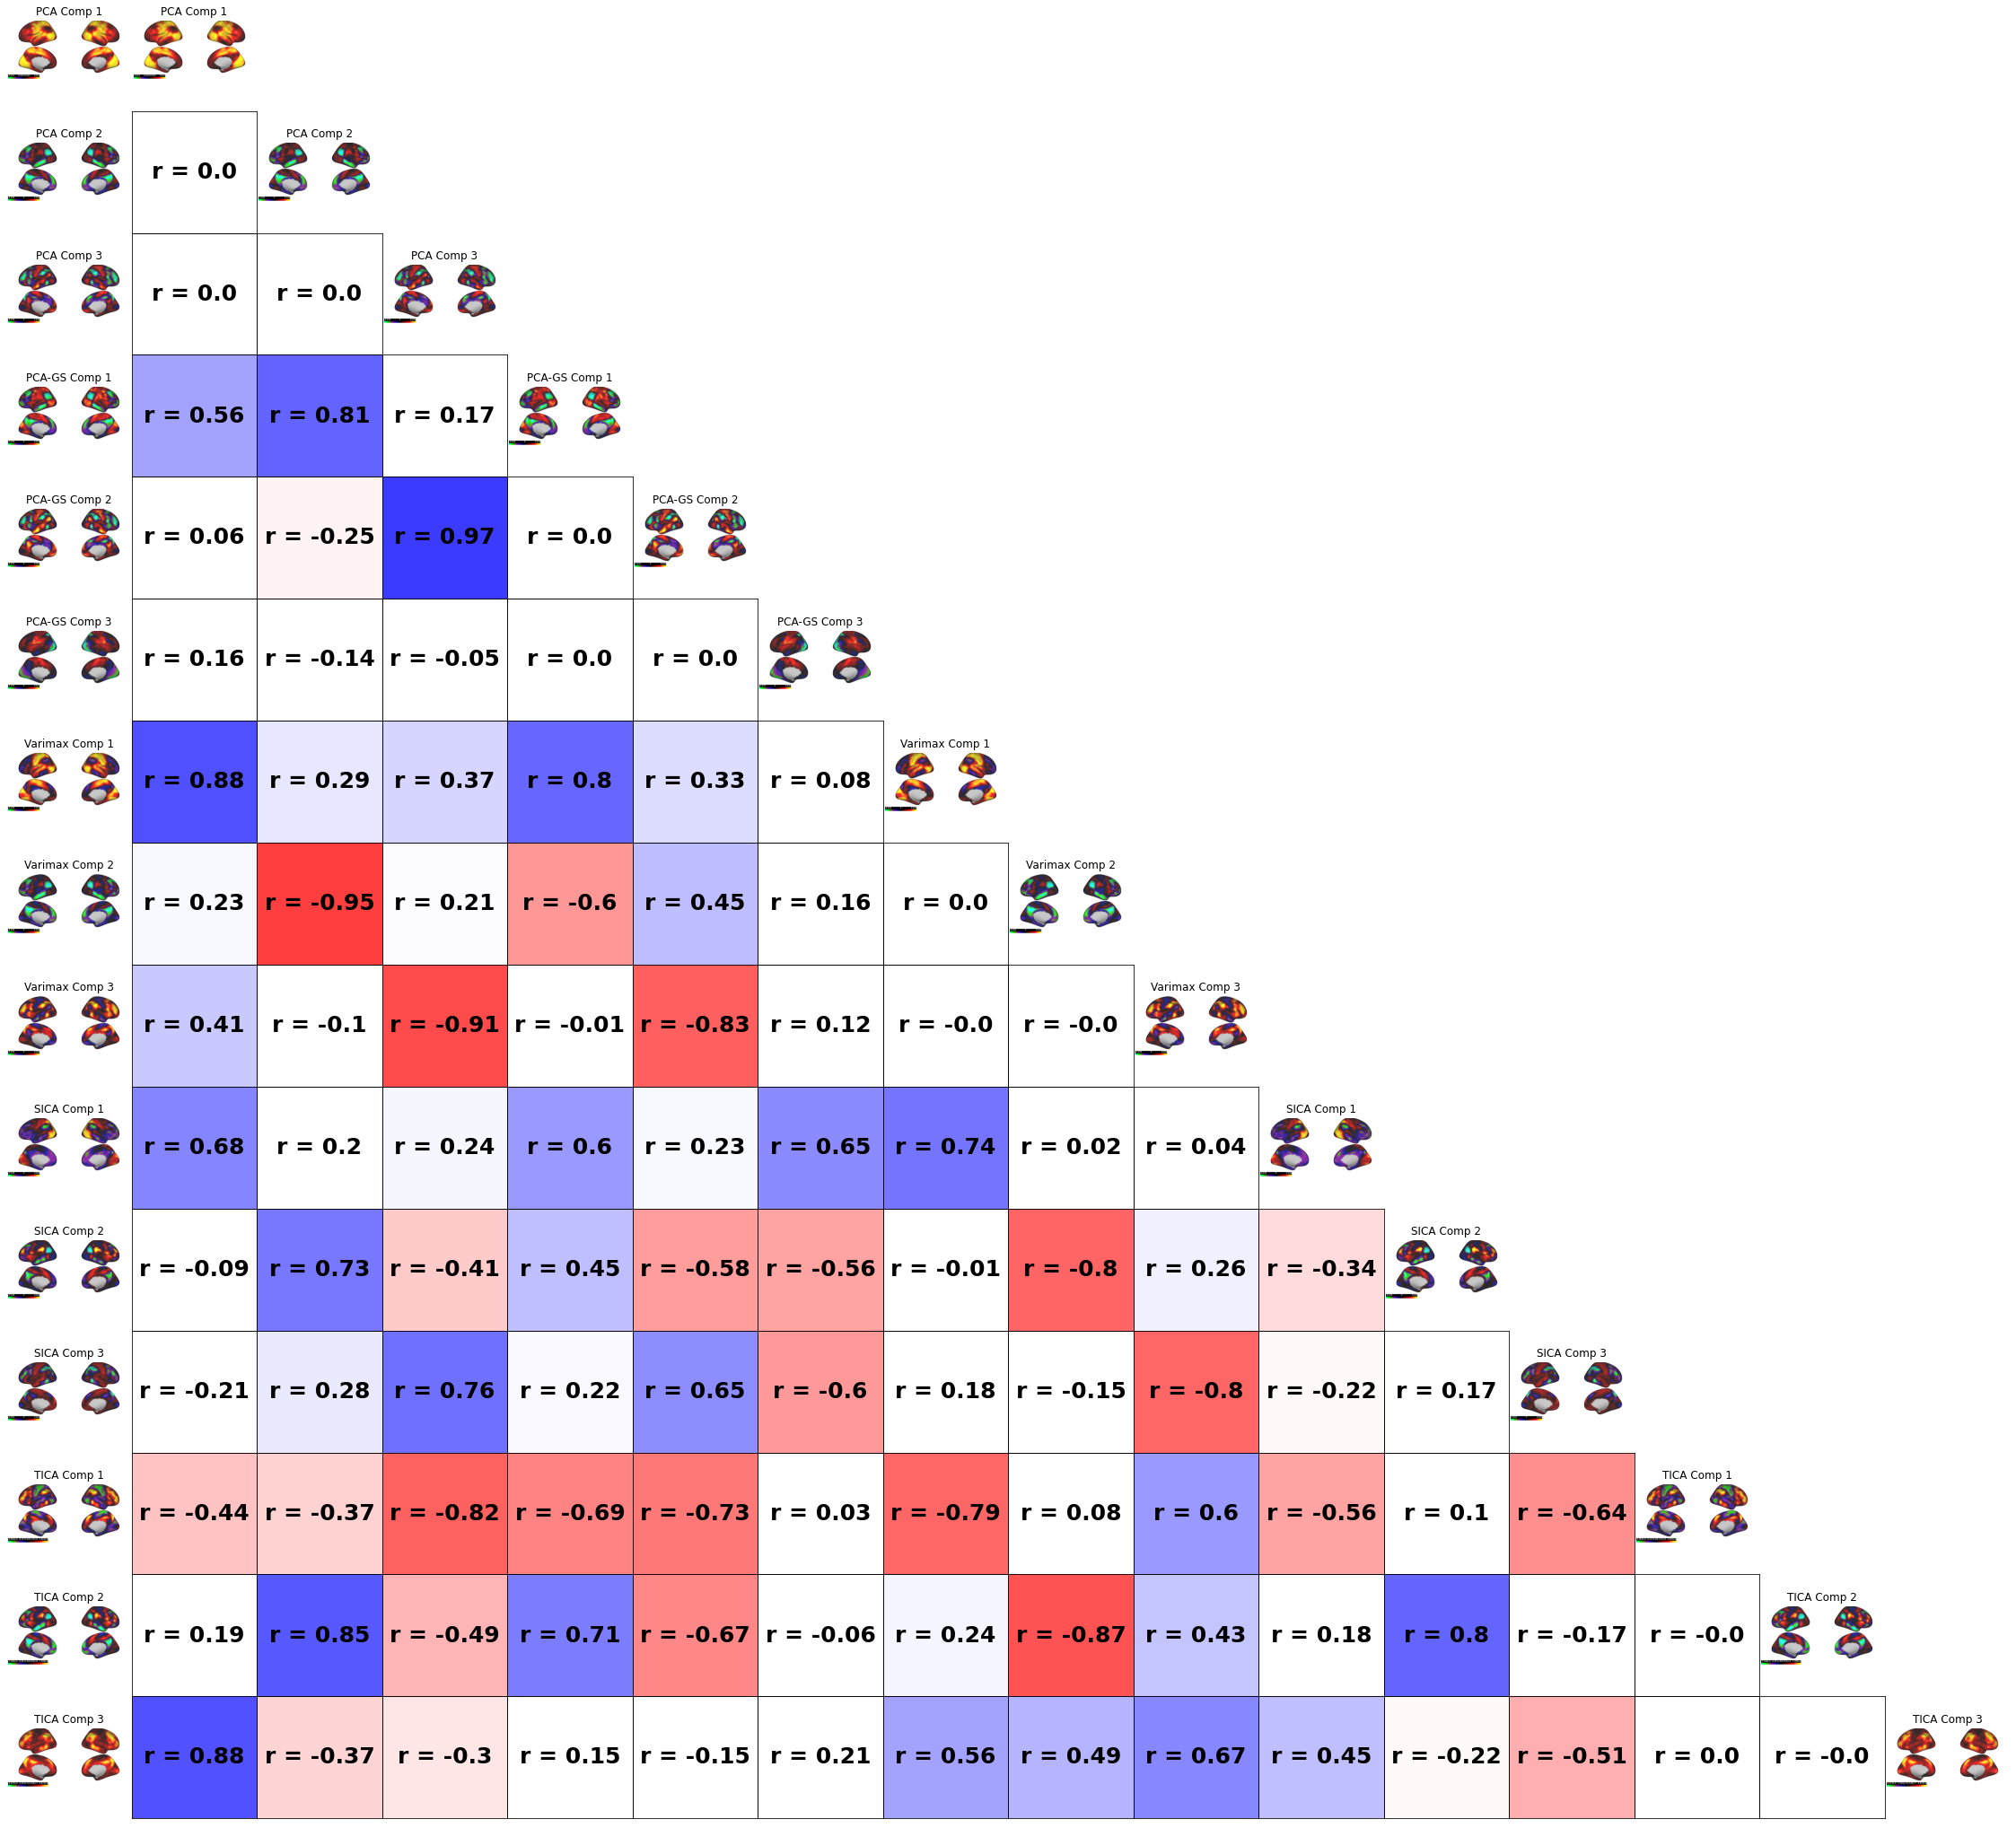

In [57]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
pcar_ts = pickle.load(open('demo_files/pcar_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))

comp1_pca, comp2_pca, comp3_pca = pca_ts[:,0], pca_ts[:,1], pca_ts[:,2]
comp1_pcar, comp2_pcar, comp3_pcar = pcar_ts[:,0], pcar_ts[:,1], pcar_ts[:,2]
comp1_varimax, comp2_varimax, comp3_varimax = varimax_ts[:,0], varimax_ts[:,1], varimax_ts[:,2]
comp1_tica, comp2_tica, comp3_tica = tica_ts[:,0], tica_ts[:,1], tica_ts[:,2]
comp1_sica, comp2_sica, comp3_sica = sica_ts[:,0], sica_ts[:,1], sica_ts[:,2]

fps = ['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png', 
       'demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png', 'demo_files/pca_rest_gs_comp2.png', 
       'demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
       'demo_files/pca_rest_varimax_comp2.png', 'demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 
       'demo_files/spatial_ica_comp2.png', 'demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 
       'demo_files/temporal_ica_comp2.png']
labels = ['PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA-GS Comp 1', 'PCA-GS Comp 2', 'PCA-GS Comp 3', 
          'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 'SICA Comp 3',
          'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3']
all_comps = [comp1_pca, comp2_pca, comp3_pca, comp1_pcar, comp2_pcar, comp3_pcar, 
             comp1_varimax, comp2_varimax, comp3_varimax, comp1_sica, comp2_sica,
             comp3_sica, comp1_tica, comp2_tica, comp3_tica]

corr_mat = np.corrcoef(all_comps)

fig = plt.figure(figsize=(40, 40))
grid = gridspec.GridSpec(16, 16, wspace=0.0, hspace=0.0)
for indx, (fp, label) in enumerate(zip(fps, labels)):
    axr = fig.add_subplot(grid[indx+1,0])
    axc = fig.add_subplot(grid[indx+1, indx+1])
    img = mpimg.imread(fp)
    axr.set_title(label); axc.set_title(label)
    axr.imshow(img); axc.imshow(img)
    axr.axis('off'); axc.axis('off')
    
br_col = [None, 'blue', 'red']
for i in range(15):
    for j in range(i):
        if i != j:
            ax = fig.add_subplot(grid[i+1, j+1])
            r = corr_mat[i,j]
            r_sign = np.int(np.sign(r))
            ax.text(0.5, 0.5, f'r = {np.round(r, 2)}',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=25, fontweight='bold',
            transform=ax.transAxes)
            ax.patch.set_facecolor(br_col[r_sign])
            ax.patch.set_alpha(max(0,r*r_sign-0.2))
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        else:
            ax = fig.add_subplot(grid)

plt.show()
# plt.savefig('results/figures/supplementaryB_timecourse_comparison.png')

### Figure B Caption

The correlation matrix of zero-lag FC topography time courses derived from PCA, PCA on global-signal regressed data, varimax-rotated PCA, spatial ICA and temporal ICA. The correlation coefficient between each pair of time series is colored from cool (strongly negative) to warm (strongly positive). For reference, the FC topographies of each analysis are displayed along the rows and diagonal of the correlation matrix. Visual examination of the correlation matrix reveals that time courses between zero-lag FC topographies have strong similarities. This is particularly the case for pairs of FC topographies with similar spatial patterns.


# <b>Supplementary Figure C. Principal Component and Functional Connectivity Gradient Topographies</b>

<font size='4'> PCA is a well-known eigendecomposition approach in fMRI research. More importantly, it is related to a wide variety of analytic approaches popular in the fMRI literature. In fact, PCA is closely related to the recent resurgence of eigendecomposition methods in resting-state fMRI analysis that has gone under the name of 'functional connectivity gradients'. The seminal study of functional connectivity gradients by Margulies et al. (2016 - PNAS) introduced the concept of connectivity gradients to the study of resting-state fMRI. To derive functional connectivity gradients, manifold learning algorithms, such as diffusion map embedding (as in Margulies et al. 2016) and Laplacian Eigenmaps, are applied to a vertex-by-vertex similarity/kernel matrix (or voxel-by-voxel). A fixed number of dimensions or manifolds are returned from the manifold learning algorithm, representing orthogonal sub-spaces that preserve the distances (in a Euclidean sense) between vertices/voxels. PCA has a very close relationship with these approaches. Both diffusion maps and Laplacian Eigenmaps involve an eigendecomposition of a modified similarity matrix, the graph Laplacian, analagous to the covariance/correlation matrix used by PCA. Further, these techniques can be viewed as special cases of kernel PCA, PCA extended to an arbitrary kernel/similarity matrix. We computed the first three Laplacian Eigenmaps from the vertex-by-vertex cosine similarity matrix, and compared them to the first three principal components from PCA and PCA of time-point normalized data (i.e. z-score normalized across all the vertices within a time point). Note, Laplacian Eigenmaps with a radial basis function kernel (non-linear kernel) was also tried and the results were very similar.</font>

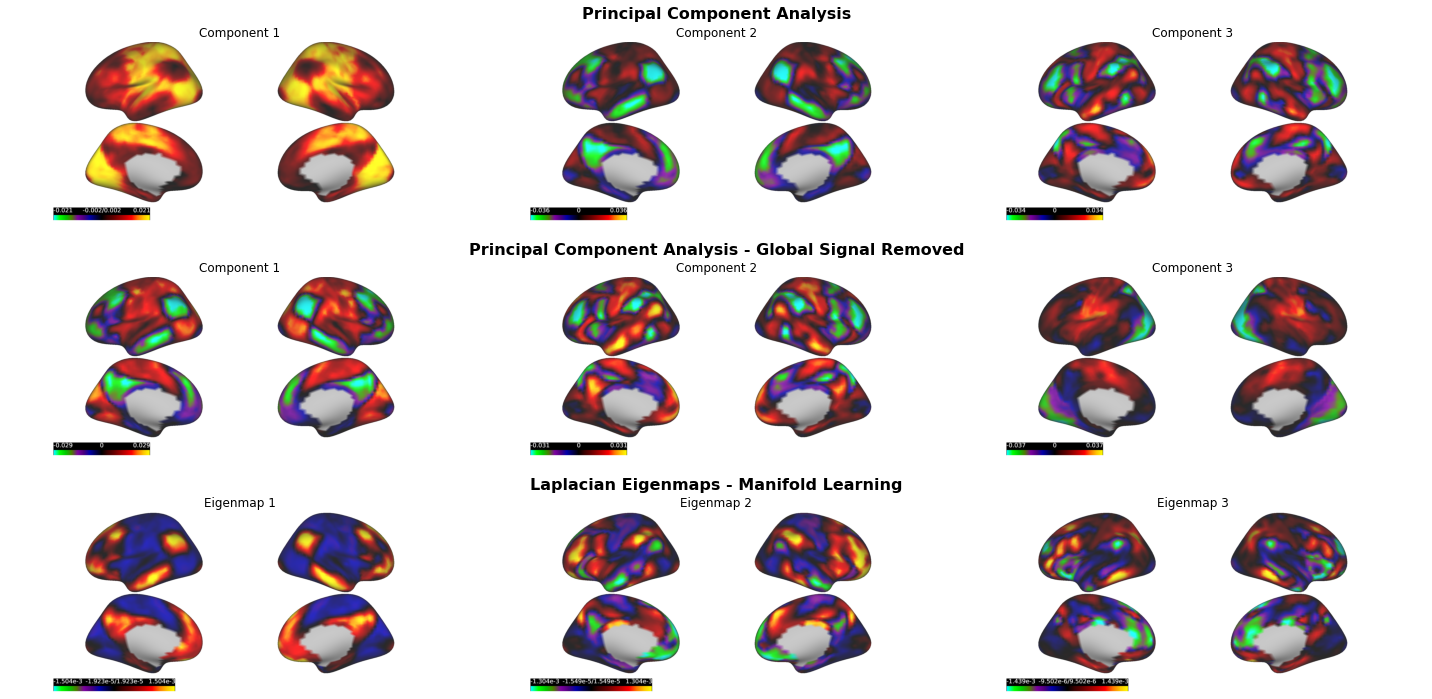

In [58]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
       ['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png', 'demo_files/pca_rest_gs_comp2.png'],
       ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png', 'demo_files/diffusion_emb_comp2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3'],
          ['Eigenmap 1', 'Eigenmap 2', 'Eigenmap 3']]
section_labels = ['Principal Component Analysis', 
                  'Principal Component Analysis - Global Signal Removed',
                  'Laplacian Eigenmaps - Manifold Learning']

fig, big_axes = plt.subplots(figsize=(20, 10) , nrows=3, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
    
indx = 0
for i, (fp_sec, label_sec) in enumerate(zip(fps, labels)):
    for j in range(3):
        indx += 1
        ax00 = fig.add_subplot(3, 3, indx)
        if j <= (len(fp_sec) - 1):
            img = mpimg.imread(fp_sec[j])
            ax00.set_title(label_sec[j])
            ax00.imshow(img)
        ax00.axis('off')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()
# plt.savefig('results/figures/supplementaryC_gradients.png')

### Figure C Caption

Displayed are the FC topography spatial weights from PCA, PCA on global-signal regressed data, and Laplacian Eigenmaps. The first and second Laplacian Eigenmaps match the second and third principal component from PCA. The first principal component is missing from the Laplacian Eigenmap and global-signal regressed PCA solutions.


# <b> Supplementary Figure D. Global BOLD Propagation Simulation.</b>

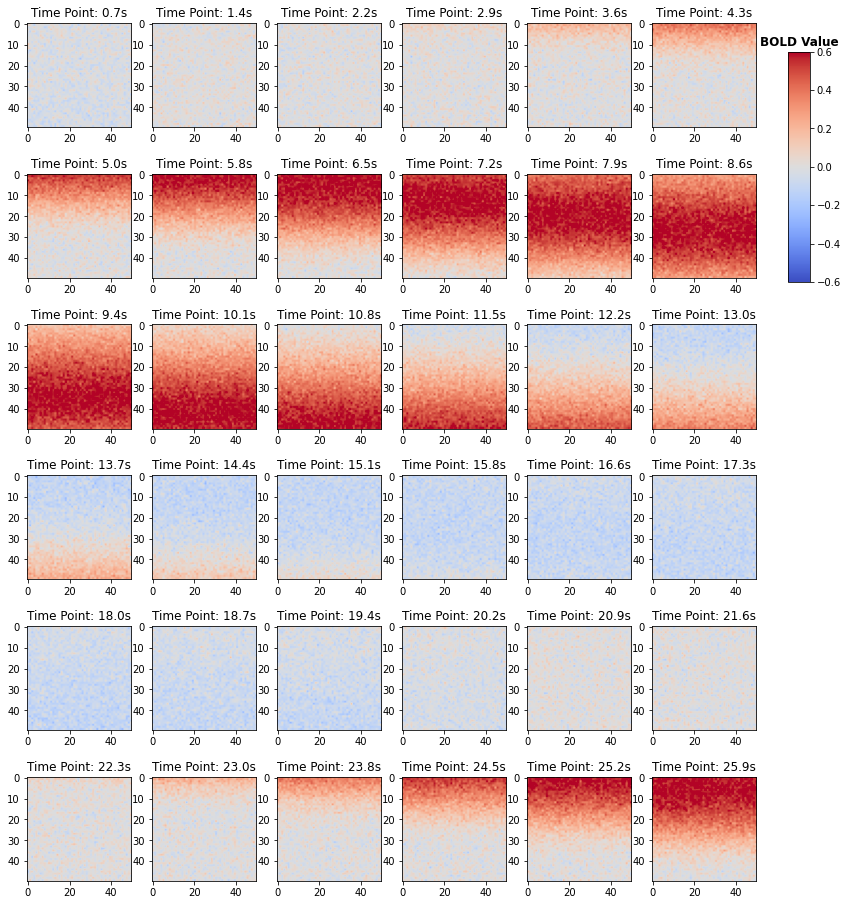

In [17]:
std_noise = 0.05; # noise-to-signal ratio
n_per_shift = 50
ts_len = 2000  
phase_jitter=10
amplitude_jitter=0.5
phase_shift = 10
start = 50
ts_sampling=0.01
n_repeats=500
n_resample = np.int(ts_len*ts_sampling/tr)*n_repeats

travel_region = range(50)

all_ts = np.zeros((50,50,n_resample))

indx = 0


for i, n in enumerate(travel_region):
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    start += phase_shift
    indx += 1


all_ts_2d = [(all_ts[i,j,:], (i,j)) for i in range(all_ts.shape[0]) for j in range(all_ts.shape[1])]
mat_2d = np.array([ts[0] for ts in all_ts_2d]).T

fig, ax = plt.subplots(6,6,figsize=(15,16))

for i, ax in enumerate(fig.axes):
    im = ax.imshow(all_ts[:,:,i], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    ax.set_title(f'Time Point: {round((i+1)*tr,1)}s')

fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.83, 0.65, 0.02, 0.2])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("BOLD Value", fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('results/figures/supplementaryD_simulation.png')

### Figure D Caption

The first ~25 sec of an artificially constructed BOLD propagation simulation. Artificial ‘vertices’ are arranged along a 50-by-50 spatial grid. Vertex time series are created by convolving simple impulse time series with the canonical hemodynamic response function. The time-series of each vertex in the grid are time-lagged such that vertex time series in the upper part of the grid peak first, while those in the bottom part peak last. As observed from the first ~25 sec snapshots of the spatial grid, a positive BOLD propagation sweeps from the top of the grid towards the bottom in the first 10 seconds. Due to the undershoot following the peak in the canonical hemodynamic response function, this positive propagation event is followed by a mirrored slightly negative propagation event.


## <b> Supplementary Figure D1. Principal Components of Global Propagation Simulation.</b>

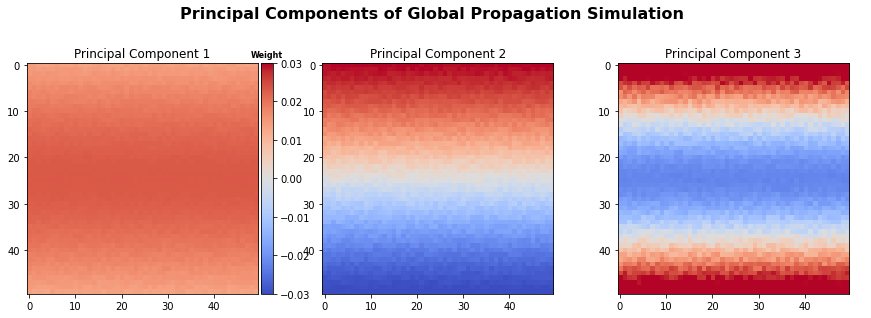

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Principal Components of Global Propagation Simulation', fontsize=16, fontweight='bold')
pca = PCA(n_components=3)
pca.fit(zscore(mat_2d))
for n in range(3):
    im = axs[n].imshow(pca.components_[n,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
    axs[n].set_title(f'Principal Component {n+1}')
    divider = make_axes_locatable(axs[n])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    if n == 0:
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_title("Weight", fontsize=8, fontweight='bold', loc='center')
    else:
        cax.axis('off')
plt.show()
# plt.savefig('results/figures/supplementaryD1_simulationPCA.png')

### Figure D1 Caption

The spatial weights for the first three principal components of the global BOLD propagation simulation. The first principal component exhibits a globally positive or negative spatial pattern, with peak weights around the center of the grid. The second component exhibits a bipolar pattern with negative and positive weights flip-flopped around the peak spatial weights in the first principal component. The third principal component is a more complex, multipolar pattern.

## <b> Supplementary Figure D2. Principal Components of Global-Signal Regression and Time-Point Centered Data Simulation</b>

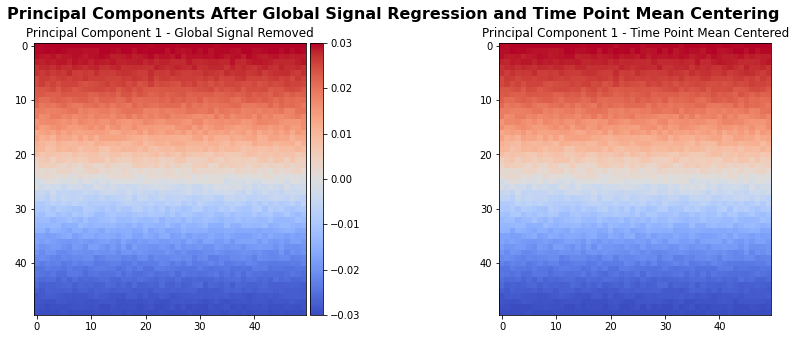

In [18]:
residual_ts_all = []
global_signal = mat_2d.mean(axis=1)
for vertex_ts in mat_2d.T:
        lin_reg = LinearRegression()
        lin_reg.fit(global_signal.reshape(-1, 1), 
                    vertex_ts.reshape(-1, 1))
        pred_ts = lin_reg.predict(global_signal.reshape(-1,1))
        residual_ts = vertex_ts.reshape(-1,1) - pred_ts
        residual_ts_all.append(residual_ts)
mat_2d_r = np.squeeze(np.array(residual_ts_all)).T

mat_2d_c = mat_2d - mat_2d.mean(axis=1, keepdims=True)

pca_r = PCA(n_components=1)
pca_r.fit(mat_2d_r)

pca_c = PCA(n_components=1)
pca_c.fit(mat_2d_c)

fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Principal Components After Global Signal Regression and Time Point Mean Centering', fontsize=16, fontweight='bold')
im = axs[0].imshow(pca_r.components_[0,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
axs[0].set_title(f'Principal Component 1 - Global Signal Removed')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
im = axs[1].imshow(pca_c.components_[0,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
axs[1].set_title(f'Principal Component 1 - Time Point Mean Centered')

plt.show()
# plt.savefig('results/figures/supplementaryD2_simulationPCA_gs.png')

### Figure D2 Caption

The spatial weights for the first principal components of the global BOLD propagation simulation with global signal regression or time-point mean centering applied beforehand . The first principal components from both preprocessing techniques exhibit the same bipolar positive-negative contrast of the second principal component from the original data.

# <b>Supplementary Figure E. Principal Component Analysis of Global-Signal Regressed and Time-Point Mean Centered Data</b>

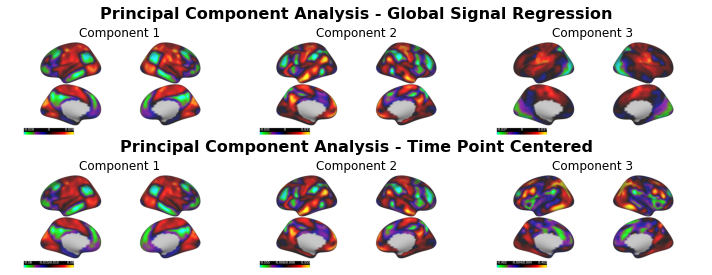

In [19]:
fps = [['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png', 'demo_files/pca_rest_gs_comp2.png'],
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3']]
section_labels = ['Principal Component Analysis - Global Signal Regression', 
                  'Principal Component Analysis - Time Point Centered']

fig, big_axes = plt.subplots(figsize=(10, 4) , nrows=2, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
    
indx = 0
for i, (fp_sec, label_sec) in enumerate(zip(fps, labels)):
    for j in range(3):
        indx += 1
        ax00 = fig.add_subplot(2, 3, indx)
        if j <= (len(fp_sec) - 1):
            img = mpimg.imread(fp_sec[j])
            ax00.set_title(label_sec[j])
            ax00.imshow(img)
        ax00.axis('off')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()
# plt.savefig('results/figures/supplementaryE_gs_centering.png')

### Figure E Caption

Spatial weights for the first three principal components from global signal regressed (top) and time-point mean centered data (bottom).

# <b>Supplementary Figure F. Spatial Weights and Temporal Projections of Principal Component Rotations.</b>

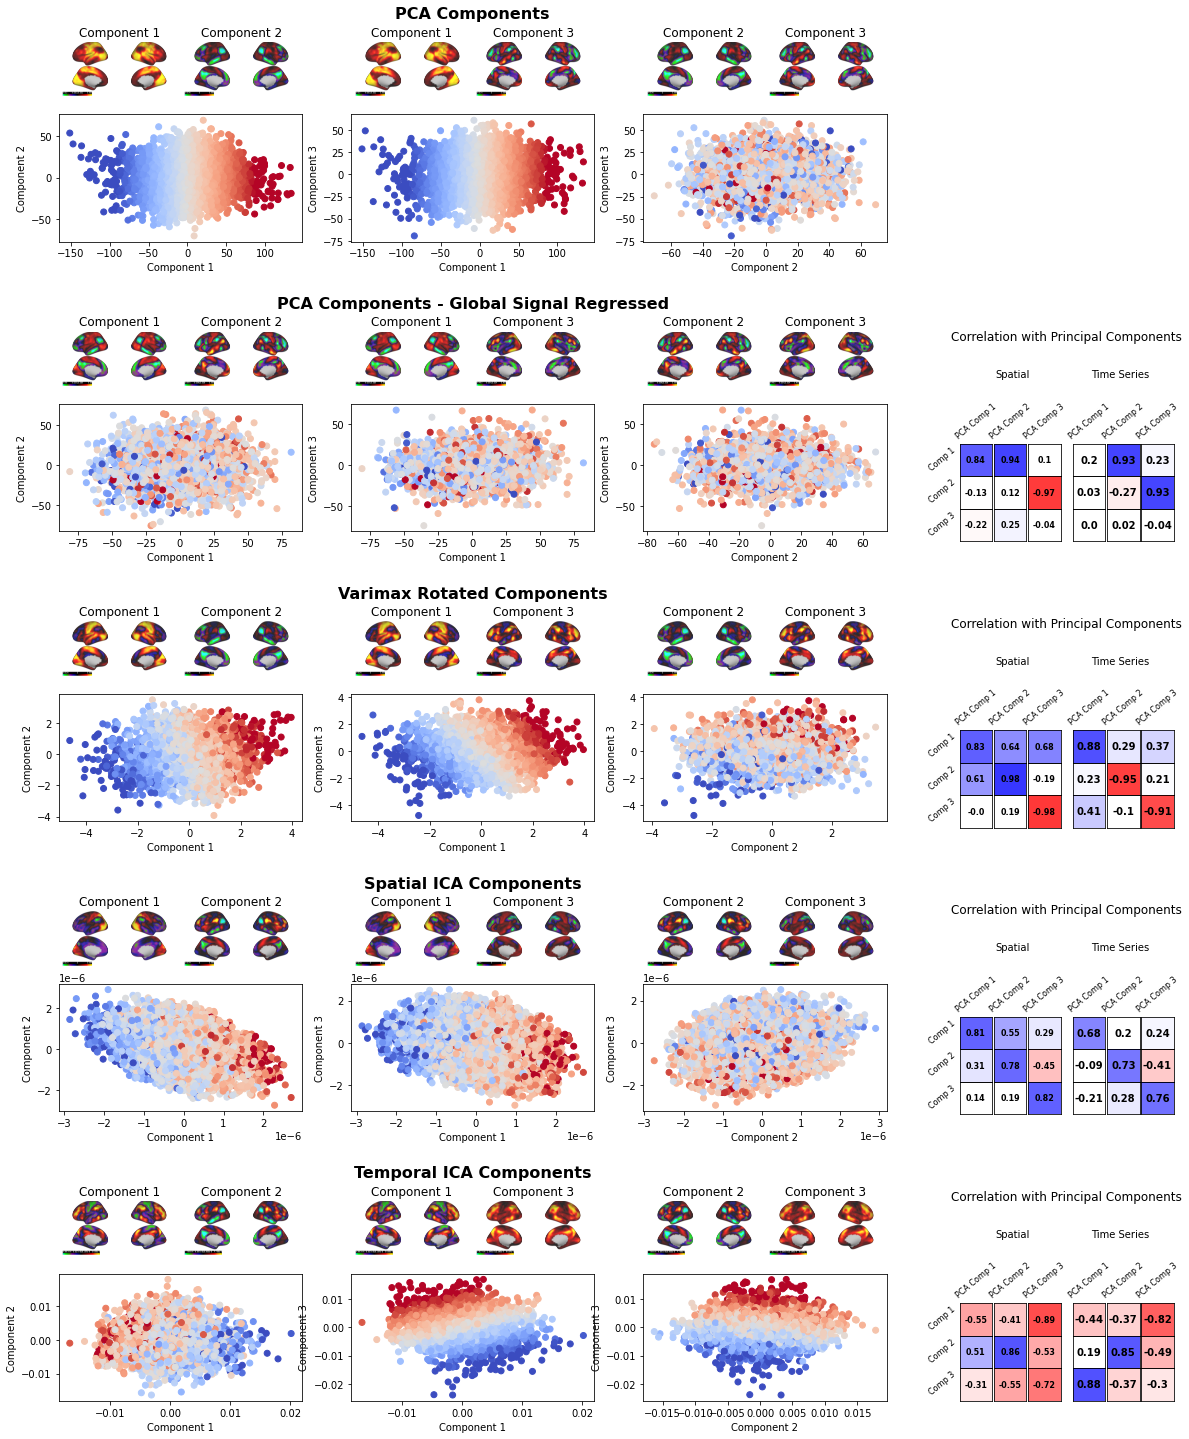

In [33]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'], 
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png'], 
       ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 'demo_files/pca_rest_varimax_comp2.png'], 
       ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
       ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png']]
cifti_fps = ['demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
             'demo_files/pca_rest_varimax.dtseries.nii', 'demo_files/s_ica.dtseries.nii', 
             'demo_files/t_ica.dtseries.nii']
section_labels = ['PCA Components', 'PCA Components - Global Signal Regressed', 'Varimax Rotated Components', 
                  'Spatial ICA Components', 'Temporal ICA Components']

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    cifti_maps_all.append(cifti_maps[:3, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()
spatial_corr = np.corrcoef(cifti_maps_all)

pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))[:,:3]
pca_ts_gs = pickle.load(open('demo_files/pca_gs_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
all_ts = [pca_ts, pca_ts_gs, varimax_ts, sica_ts, tica_ts]
time_corr = np.corrcoef(np.hstack(all_ts).T)

rand_indx = rand.permutation(pca_ts.shape[0])[:5000]
pc_scores = pca_ts[rand_indx, :]
pc_gs_scores = pca_ts_gs[rand_indx, :]
varimax_scores = varimax_ts[rand_indx, :]
sica_scores = sica_ts[rand_indx,:]
tica_scores = tica_ts[rand_indx,:]
all_ts_sample = [pc_scores, pc_gs_scores, varimax_scores, sica_scores, tica_scores]

perc_99 = round(np.percentile(pc_scores[:,0],99), 2)
perc_1 = round(np.percentile(pc_scores[:,0],1), 2)

fig = plt.figure(figsize=(20,25), constrained_layout=False)
gspec = fig.add_gridspec(5,1, wspace=0.5, hspace=0.45)
gspec2 = fig.add_gridspec(5,2, wspace=0.2)

for row, label in enumerate(section_labels):
    big_ax = fig.add_subplot(gspec[row,:])
    big_ax.set_title(f"{label}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')

indx=3
br_col = [None, 'blue', 'red']
xy_ax_ord = [[0,1], [0,2], [1,2]]

for i, (ts, fp) in enumerate(zip(all_ts_sample, fps)): 
    g_sub0 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gspec[i], hspace=0.2)
    for n in range(3):
        sub_grid = g_sub0[:,n].subgridspec(2,2, wspace=0, height_ratios=[0.3,0.7])
        ax1 = fig.add_subplot(sub_grid[0,0])
        img = mpimg.imread(fp[xy_ax_ord[n][0]])
        ax1.set_title(f'Component {xy_ax_ord[n][0]+1}', fontsize=12)
        ax1.imshow(img)
        ax1.axis('off')

        ax2 = fig.add_subplot(sub_grid[0,1])
        img = mpimg.imread(fp[xy_ax_ord[n][1]])
        ax2.set_title(f'Component {xy_ax_ord[n][1]+1}', fontsize=12)
        ax2.imshow(img)
        ax2.axis('off')

        ax3 = fig.add_subplot(sub_grid[1,:])
        x_ts = ts[:,xy_ax_ord[n][0]]
        y_ts = ts[:,xy_ax_ord[n][1]]
        ax3.scatter(x_ts, y_ts, c=pc_scores[:,0], cmap='coolwarm', vmin=perc_1, vmax=perc_99)
        ax3.set_xlabel(f'Component {xy_ax_ord[n][0]+1}', fontsize=10)
        ax3.set_ylabel(f'Component {xy_ax_ord[n][1]+1}', fontsize=10)
#         asp_ratio = (np.max(y) - np.min(y))/(np.max(x) - np.min(x))
        pos1 = ax3.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 + 0.01,  pos1.width, pos1.height] 
        ax3.set_position(pos2) # set a new position

    if i > 0:
        g_sub_lg = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gspec2[i, :], hspace=0, wspace=0.1)
        g_sub0 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=g_sub_lg[0, :], hspace=0, wspace=0)
        g_sub1 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=g_sub_lg[1, 0], hspace=0, wspace=0)
        g_sub2 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=g_sub_lg[1, 1], hspace=0, wspace=0)
        big_ax_title = fig.add_subplot(g_sub0[0,:])
        big_ax_title.set_title(f"Correlation with Principal Components", fontsize=12)
        big_ax_title.axis('off')
        big_ax = fig.add_subplot(g_sub0[1,0])
        big_ax.set_title(f"Spatial\n", fontsize=10)
        big_ax.axis('off')
        big_ax = fig.add_subplot(g_sub0[1,1])
        big_ax.set_title(f"Time Series\n", fontsize=10)
        # Turn off axis lines and ticks of the big subplot 
        big_ax.axis('off')
        for x in range(3):
            for y in range(3):
                ax1 = fig.add_subplot(g_sub1[x, y])
                ax2 = fig.add_subplot(g_sub2[x, y])
                r_space = spatial_corr[indx,y]
                r_time = time_corr[indx,y]
                r_sign_space = np.int(np.sign(r_space))
                r_sign_time = np.int(np.sign(r_time))
                ax1.text(0.5, 0.5, f'{np.round(r_space, 2)}',
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=8, fontweight='bold',
                         transform=ax1.transAxes)
                ax2.text(0.5, 0.5, f'{np.round(r_time, 2)}',
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=10, fontweight='bold',
                         transform=ax2.transAxes)
                ax1.patch.set_facecolor(br_col[r_sign_space]); 
                ax2.patch.set_facecolor(br_col[r_sign_time])
                ax1.patch.set_alpha(max(0,r_space*r_sign_space-0.2))
                ax2.patch.set_alpha(max(0,r_time*r_sign_time-0.2))
                ax1.axes.xaxis.set_visible(False); ax2.axes.xaxis.set_visible(False);
                ax1.axes.yaxis.set_visible(False); ax2.axes.yaxis.set_visible(False);
                ax1.set_aspect('equal'); ax2.set_aspect('equal')
                if x == 0:
                    t = ax1.set_title(f'PCA Comp {y+1}', fontsize=8)
                    t.set_rotation(40)
                    t = ax2.set_title(f'PCA Comp {y+1}', fontsize=8)
                    t.set_rotation(40)
                if y == 0:
                    t = ax1.text(-1, 0.2, f'Comp {x+1}', fontsize=8)
                    t.set_rotation(40)

            indx+=1

gspec.update(right=0.7)
gspec2.update(left=0.75, hspace=0.47, top=0.87)
plt.show()
# plt.savefig('results/figures/supplementaryF_rotations.png')

### Figure F Caption

Spatial weights and temporal projections of principal component rotation methods, including varimax rotation, spatial ICA and temporal ICA. To illustrate how each rotation method relates to the global phase of the QPP, we projected a random selection of time points (N=5000) from the original BOLD time series into each of the rotated three-component spaces. Each time point is colored according to their position along the original first principal component axis from cool (global negative propagation) to warm (global positive propagation). The temporal projections of each rotation method are displayed in pairwise scatter plots for all three components. Examination of the colored time points in each rotated component space provides information regarding the relationship between the rotated components and the global phase of the QPP. Note, the coloring of each time point along the first principal component axis is fixed - i.e. each time point maintains its original color mapping along the first principal component in the rotated component space.. In addition, to show the effects of global signal regression on the global phase of the QPP (first principal component), we display the spatial weights and temporal projections of PCA applied to global-signal regressed data. To the right of each panel, the spatial and temporal correlations (i.e. correlations between temporal projections) between the rotated components and the original principal component time series are displayed in the left and right correlation matrices, respectively. The rows of the correlation matrices correspond to the rotated components and the columns correspond to the original principal components. Correlation coefficients in the spatial and temporal correlation matrices are displayed from cool (strongly positive) to warm (strongly negative). As can be observed visually, from the spatial weights and temporal projections, and quantitatively from the correlation matrices, the rotated component solutions exhibit strong similarities with the original, unrotated principal component solutions. This indicates that the rotated component solutions describe very similar spatial and temporal properties of resting-state BOLD signals. Further,  the temporal structure of the global phase of the QPP is preserved in the rotated component solutions, as illustrated by the separation between cool blue and warm red time points in rotated component spaces. This is not the case for PCA on global-signal regressed data, where global signal regression removes the first principal component axis before analysis.


# <b>Supplementary Figure G. Comparison of Lag Projections With and Without Global Signal Regression.</b>

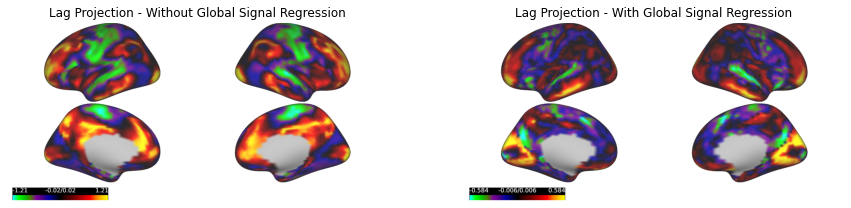

In [42]:
fps = ['demo_files/lag_projection.png', 'demo_files/lag_projection_gs.png']
labels = ['Lag Projection - Without Global Signal Regression', 
          'Lag Projection - With Global Signal Regression']

fig, axs = plt.subplots(figsize=(15, 15) , nrows=1, ncols=2) 
img = mpimg.imread(fps[0])
axs[0].imshow(img)
axs[0].set_title(labels[0])
axs[0].axis('off')

img = mpimg.imread(fps[1])
axs[1].imshow(img)
axs[1].set_title(labels[1])
axs[1].axis('off')


fig.set_facecolor('w')
plt.show()
# plt.savefig('results/figures/supplementaryG_lag_projection.png')

### Figure G Caption

Lag projections with and without global signal regression as a preprocessing step. Values on each cortical map represent the average time-delay between each cortical vertex and all others. Time-delay values are colored from light green/blue (earlier in time) to bright yellow/green (later in time). The range between the earliest and latest time-delay values are significantly shorter for lag projections on global-signal regressed data.


## Appendix H - Code to Project CAP Time Points into PCA Space

<font size='4'>The following code was used to project suprathreshold CAP time points from Precuneus and Somatosensory seeds to the three-dimensional space formed by the first three principal components. The plot is displayed in <b>Figure 6</b>. CAPs analysis must already be run and placed in the 'results' folder in the base repo. The preprocessed data used to generate the CAPs clusters must also be in the appropriate location in the 'data' folder in the base repo.</font>

In [ ]:
# %%capture 
# # ^ supress printing
# caps_p_res = pickle.load(open('results/caps_precuneus_results_c2.pkl', 'rb'))
# caps_sm_res = pickle.load(open('results/caps_sm_results_c2.pkl', 'rb'))
# V = pickle.load(open('demo_files/pca_eigen.pkl', 'rb')) # X = USV

# group_data_orig, hdr, zero_mask, _ = load_data_and_stack(50, 'gifti', global_signal=0)
# group_data_orig = zscore(group_data_orig)
# selected_data_p = group_data_orig[caps_p_res[2], :]
# selected_data_sm = group_data_orig[caps_sm_res[2], :]

# selected_data_p_proj = selected_data_p @ V.T
# selected_data_sm_proj = selected_data_sm @ V.T

# pickle.dump([selected_data_p_proj, selected_data_sm_proj], open('demo_files/caps_suprathres_points.pkl', 'wb'))